# 37.3 Final Capstone

### Whisky Recommendation Service

In this project, I will be using data scraped from [The Whisky Advocate](https://www.whiskyadvocate.com/ratings-reviews/?search=&submit=+&brand_id=0&rating=0&price=0&category=1&styles_id=0&issue_id=0). The data contains 5000+ whiskies containing variables such as ratings, reviews, label name, year rated, category, and subcategory. 

The code for the website scraping is also a part of this project, but is not included in this notebook. It can be found [here](https://github.com/dancassin/Thinkful/blob/master/37.3%20Whisky%20Scraping.ipynb)

In [221]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import itertools

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as grid_spec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objects as go


# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import gensim
from gensim.models import Word2Vec

# Supervised ML
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Unsupervised ML
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


# Decomp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

sns.set_style('dark')
plt.style.use('dark_background')
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'sans-serif']

pd.options.display.float_format = '{:,.2f}'.format

%config InlineBackend.figure_format = 'retina'



In [3]:
whisky = pd.read_csv('whisky1.csv', skiprows=0, index_col=0, 
                     dtype= {'year':'Int64','age':'Int64', 'vintage':'Int64'} )

# EDA
---
<br></br>
Let's begin by exploring the data

In [4]:
whisky.info()
whisky.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5208 entries, 0 to 5207
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       5208 non-null   int64  
 1   label        5208 non-null   object 
 2   subcategory  5208 non-null   object 
 3   category     5208 non-null   object 
 4   review       5208 non-null   object 
 5   reviewer     5208 non-null   object 
 6   year         5208 non-null   Int64  
 7   abv          5182 non-null   float64
 8   price        5208 non-null   float64
 9   age          1954 non-null   Int64  
 10  vintage      1164 non-null   Int64  
dtypes: Int64(3), float64(2), int64(1), object(5)
memory usage: 503.5+ KB


rating                                              label  \
0      97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1      97        Bowmore 46 year old (distilled 1964), 42.9%   
2      97                     Johnnie Walker Blue Label, 40%   
3      96    Glenlivet Cellar Collection 1969 vintage, 50.8%   
4      96  The Macallan 29 year old 1976 Vintage (Cask #1...   

             subcategory category  \
0     Single Malt Scotch   Scotch   
1     Single Malt Scotch   Scotch   
2  Blended Scotch Whisky   Scotch   
3     Single Malt Scotch   Scotch   
4     Single Malt Scotch   Scotch   

                                              review         reviewer  year  \
0  What impresses me most is how this whisky evol...     John Hansell  2008   
1  There have been some legendary Bowmores from t...       Dave Broom  2012   
2  Magnificently powerful and intense. Caramels, ...  Jonny McCormick  2018   
3  It’s great that Glenlivet releases whiskies un...     John Hansell  2007   
4  Classic sherry cask-aged Macallan. Antique amb...     John Hansell  2008   

    abv     price   age  vintage  
0 40.50  4,500.00    42     1964  
1 42.90 13,500.00    46     1964  
2 40.00    225.00  <NA>     <NA>  
3 50.80    750.00  <NA>     1969  
4 45.40  1,500.00    29     1976

What all is included under the heading "whisky"?

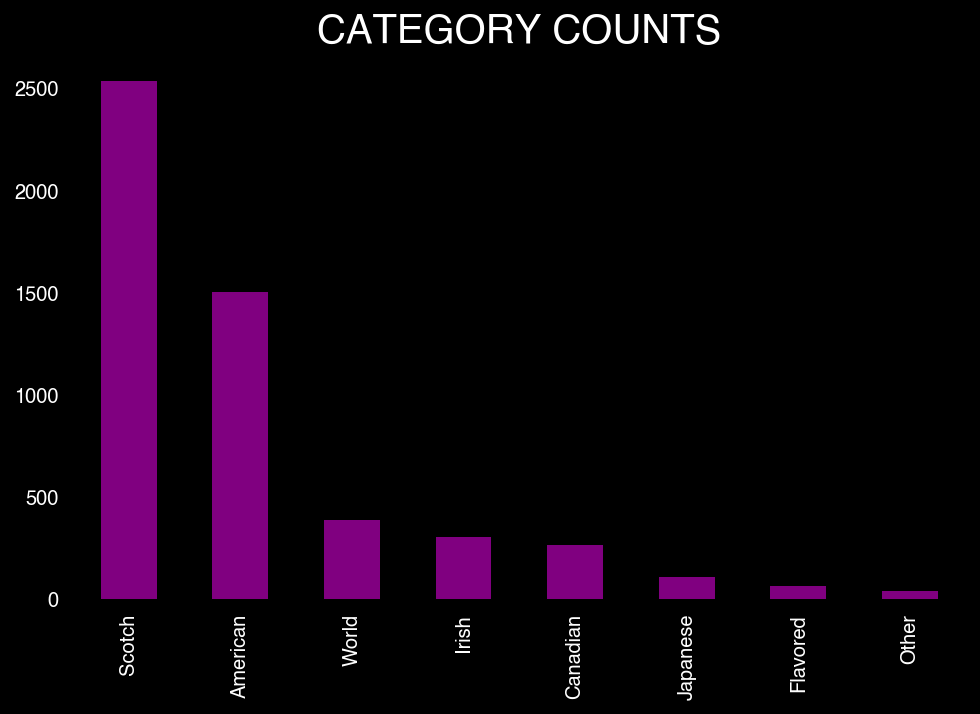

In [14]:
# Category counts
category_counts = whisky[['label','category']].groupby('category').count().sort_values(by='label',ascending=False)

fig, ax = plt.subplots(figsize=(8,5))
category_counts.plot(kind='bar', 
                     color='purple',
                    linewidth=0, legend=False, ax=ax)

for i in ['top', 'bottom','right','left']:
    ax.spines[i].set_visible(False);

ax.set_title('CATEGORY COUNTS',fontsize=20, )
ax.set_xlabel('');

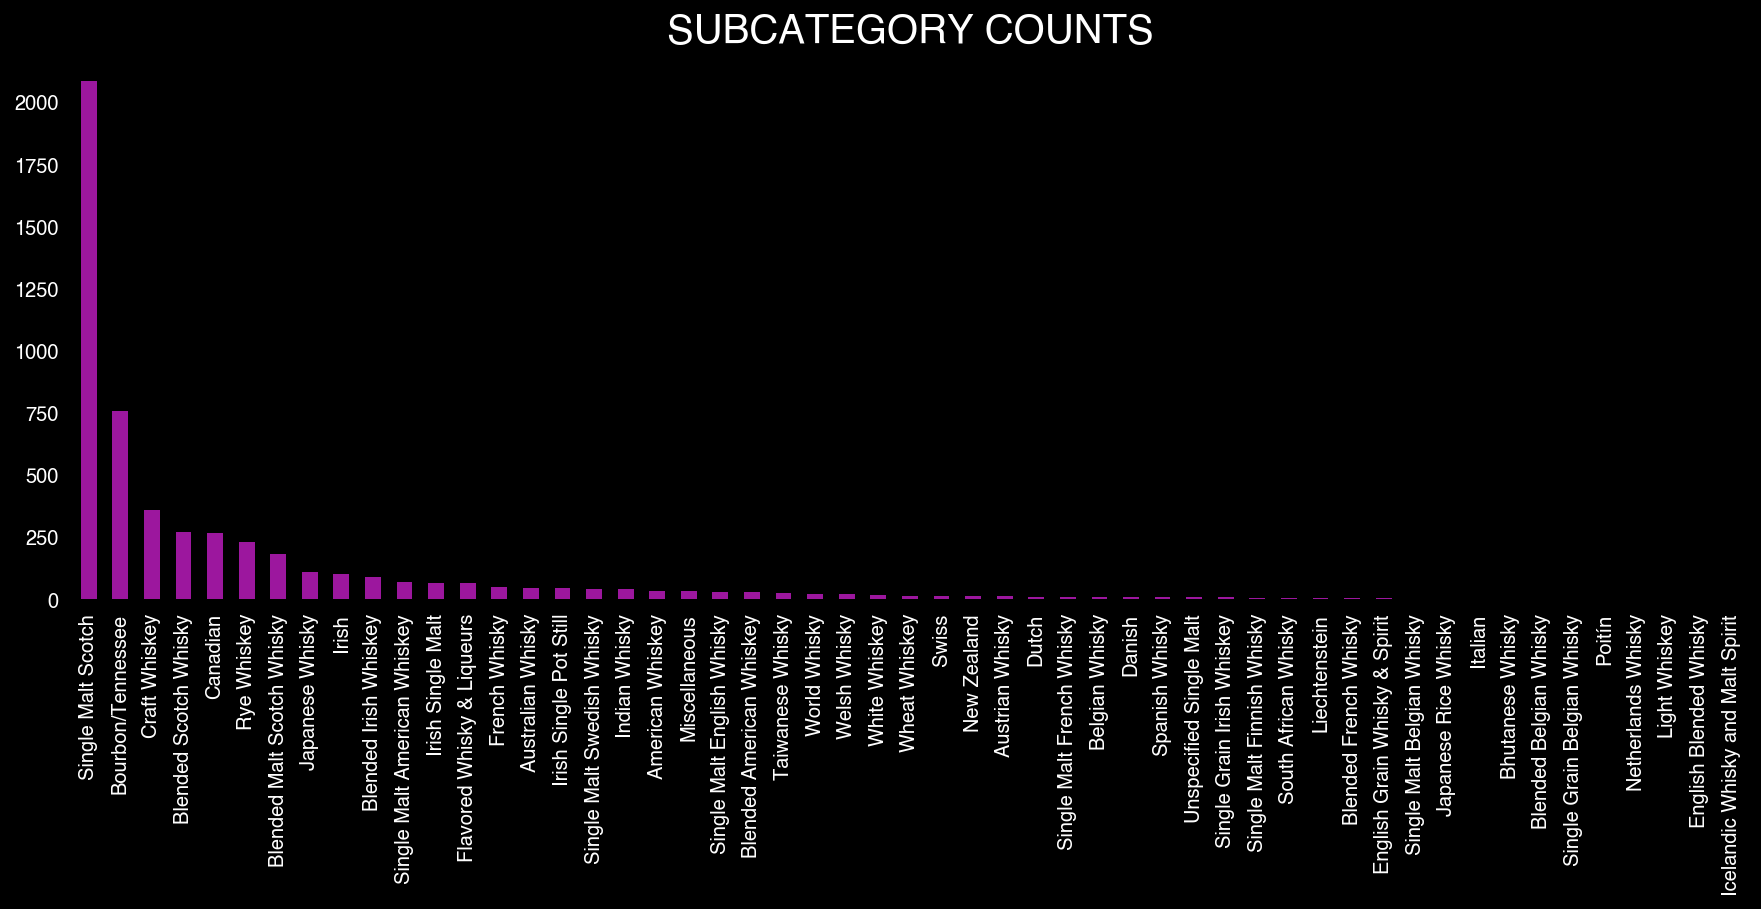

In [15]:
# Subcategory counts
category_counts = whisky[['label','subcategory']].groupby('subcategory').count().sort_values(by='label',ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
category_counts.plot(kind='bar', 
                     color=sns.color_palette('plasma',n_colors=2),
                     linewidth=0, legend=False, ax=ax)

for i in ['top', 'bottom','right','left']:
    ax.spines[i].set_visible(False);

ax.set_title('SUBCATEGORY COUNTS',fontsize=20, )
ax.set_xlabel('');

Ratings are a key part of the Whisky Advocate website, let's take a look at their distribution

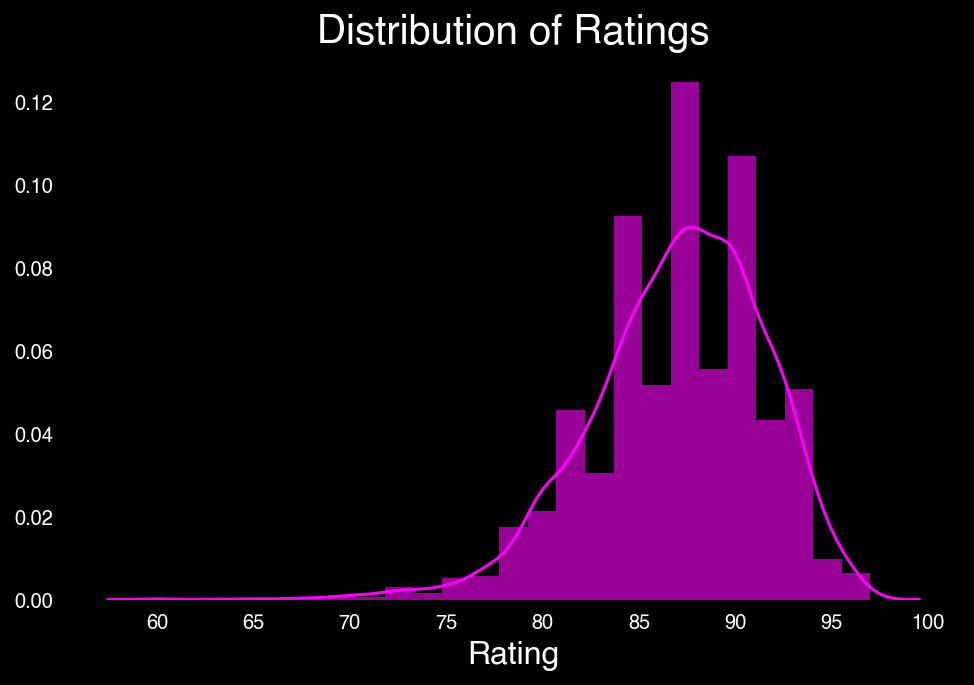

In [7]:
# plotting ratings distribution
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(whisky.rating, bins=25, color='magenta', ax=ax, hist_kws={'linewidth':0, 'alpha':.6})
ax.set_title('Distribution of Ratings', fontsize=20)
ax.set_xticks(np.arange(60,101,5))
ax.set_xlabel('Rating', fontsize=16);

for i in ['top','right','left', 'bottom']:
    ax.spines[i].set_visible(False)

In [233]:
print(f'Max rating: {whisky.rating.max()}')
print(f'Min rating: {whisky.rating.min()}')

Max rating: 97
Min rating: 60


How good is a good whisky?

In [237]:
whisky[whisky.rating==97]
# Looks like only 5 total are deserving of their highest rating

rating                                              label  \
0         97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1         97        Bowmore 46 year old (distilled 1964), 42.9%   
2         97                     Johnnie Walker Blue Label, 40%   
2838      97  Parker's Heritage Collection, 'Golden Annivers...   
2839      97  Four Roses Limited Edition Small Batch (2013 R...   

                subcategory  category  \
0        Single Malt Scotch    Scotch   
1        Single Malt Scotch    Scotch   
2     Blended Scotch Whisky    Scotch   
2838      Bourbon/Tennessee  American   
2839      Bourbon/Tennessee  American   

                                                 review         reviewer  \
0     What impresses me most is how this whisky evol...     John Hansell   
1     There have been some legendary Bowmores from t...       Dave Broom   
2     Magnificently powerful and intense. Caramels, ...  Jonny McCormick   
2838  This bottling celebrates master distiller Park...     John Hansell   
2839  A marriage of 13 and 18 year old bourbons. A m...     John Hansell   

      year   abv     price   age  vintage  \
0     2008 40.50  4,500.00    42     1964   
1     2012 42.90 13,500.00    46     1964   
2     2018 40.00    225.00  <NA>     <NA>   
2838  2009 50.00    150.00  <NA>     <NA>   
2839  2013 51.50     85.00  <NA>     2013   

                                       text_for_unigram  \
0     impress evolv incred complex viscous sticki to...   
1     legendari bowmor mid bite equal share remark a...   
2     magnific power intens caramel dri peat eleg ci...   
2838  bottl celebr master distil parker beam year se...   
2839  marriag year bourbon matur eleg silki textur e...   

                                        text_for_bigram  
0     black bowmor 42 year 1964 vintag 40 impress ev...  
1     bowmor 46 year distil 1964 42 legendari bowmor...  
2     johnni walker blue label 40 magnific power int...  
2838  parker heritag collect golden anniversari 50 b...  
2839  rose limit edit small batch 2013 releas 51 mar...

In [238]:
whisky.iloc[1].review

"There have been some legendary Bowmores from the mid-60s and this is every bit their equal. All of them share a remarkable aroma of tropical fruit, which here moves into hallucinatory intensity: guava, mango, peach, pineapple, grapefruit. There’s a very light touch of peat smoke, more a memory of Islay than the reality. Concentrated; even at low strength the palate is silky, heady, and haunting, and lasts forever in the dry glass. A legend is born. (Eight bottles only for the U.S.) Editor's Choice."

"Legend", "remarkable", "intensity", "haunting". Sounds very enticing, but maybe not worth the \$13,500 price tag?

How bad is a bad whisky?

In [9]:
whisky[whisky.rating==60]
# Only 2 are deserving of their lowest

rating                                              label  \
4339      60                                       Cavalry, 45%   
4340      60  Woodford Reserve Master’s Collection Five Malt...   

                   subcategory  category  \
4339         Bourbon/Tennessee  American   
4340  Blended American Whiskey  American   

                                                 review      reviewer  year  \
4339  Although it’s not on the label, Cavalry uses t...  Fred Minnick  2016   
4340  Four barley types—two row, pale chocolate, kil...  Fred Minnick  2016   

       abv  price   age  vintage  
4339 45.00  30.00  <NA>     <NA>  
4340 45.20  50.00  <NA>     <NA>

In [236]:
whisky.iloc[4340].review

'Four barley types—two row, pale chocolate, kiln coffee, and Carafa—and malted wheat; aged 6 months in used Woodford Reserve Double Oaked barrels. Initial pungency and varnish. Then freshly-cut grass, petrol, wood shavings, and a slight hint of chocolate. New make mouthfeel. A hint of honey and milk chocolate is quickly overtaken by an astringent finish. In another few years, maybe this will become more palatable, but this is far from ready, and bourbon remains this distiller’s strong suit. 375ml'

"Pugency", "varnish", "petrol", "astringent". Sounds fun. Obviously deserving of a bad review.

Let's look at the rate of reviews over the years

In [10]:
print(sorted(whisky.year.unique()))
# 1992 is the odd one out and we aren't completely through 2020, so we'll filter those out in the year analysis

[1992, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


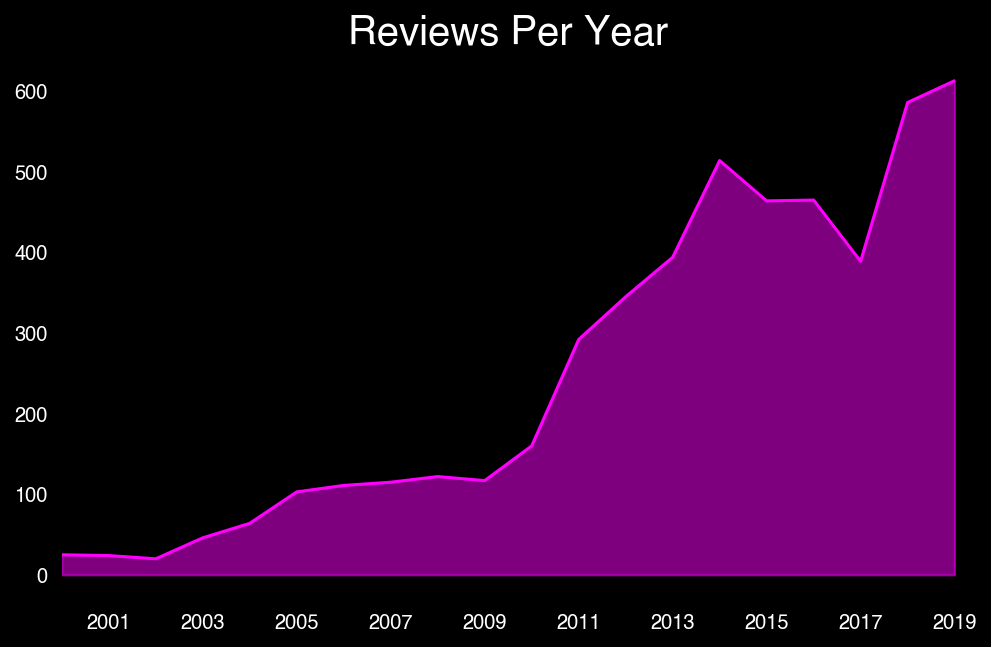

In [11]:
# number of reviews per year
years_filtered = whisky[(whisky.year < 2020)&(whisky.year>1992)]
reviews_by_year = years_filtered[['review','year']].groupby('year').count()

fig, ax = plt.subplots(figsize=(8,5))

reviews_by_year.plot(color='magenta', legend=False, ax=ax)
ax.fill_between(np.arange(2000,2020), reviews_by_year.review, color='magenta', alpha=.5)
ax.set(xlim=(2000,2019), xticks=[2001,2003,2005,2007,2009,2011,2013,2015,2017,2019], xlabel='')
ax.set_title('Reviews Per Year', fontsize=20)

for i in ['top','bottom','right','left']:
    ax.spines[i].set_visible(False)

As the popularity of clear alcohols such as gin and vodka waned, dark alcohols like bourbon and scotch saw an explosion around 2010, and the amount of reviews reflects this trend.

Let's also look at the reviewers themselves

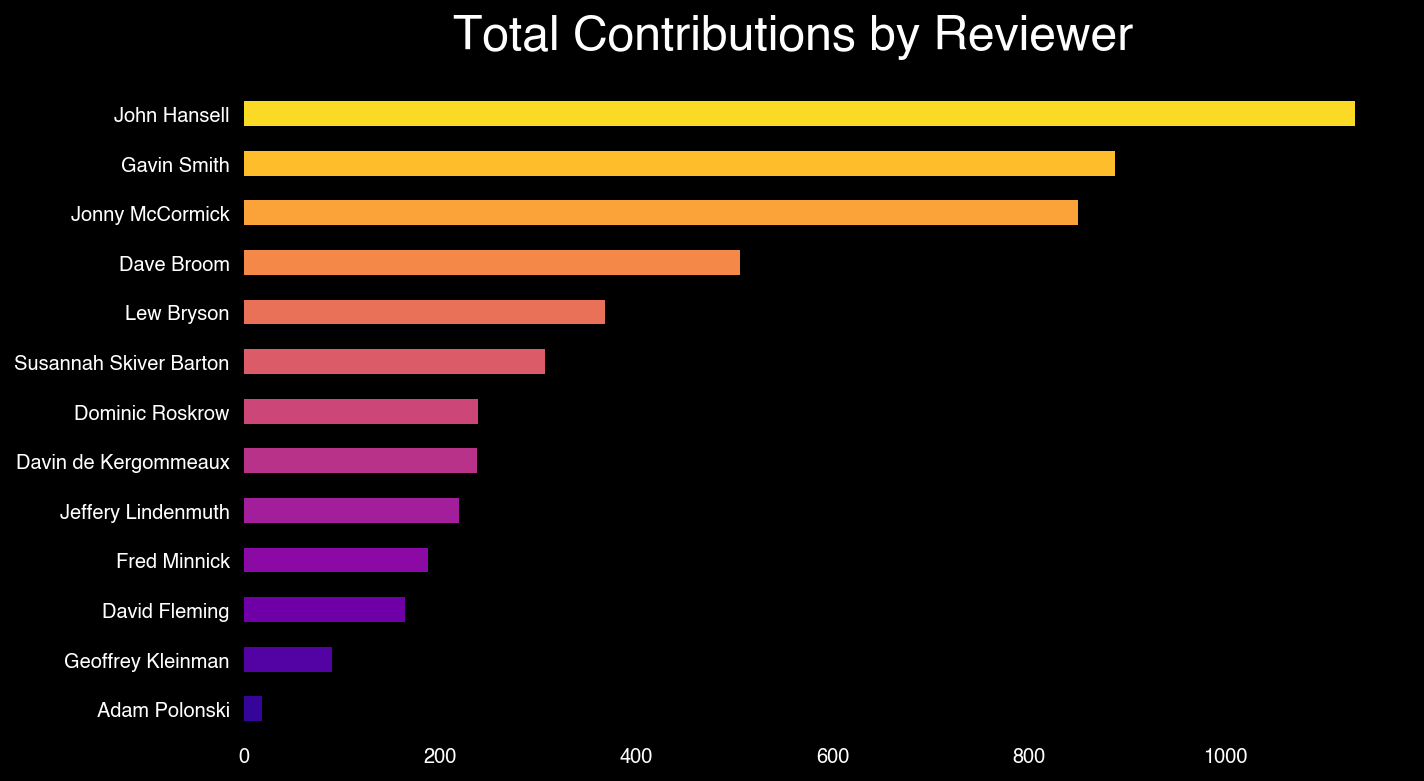

In [12]:
# reviews per reviewer
reviews_by_reviewer = whisky[['review','reviewer']].groupby('reviewer').count().sort_values(by='review')

fig,ax = plt.subplots(figsize=(10,5))
reviews_by_reviewer.plot(kind='barh', y='review', legend=None, 
                         color=sns.color_palette('plasma',n_colors=len(whisky.reviewer.unique())),
                         linewidth=0, ax=ax);

for i in ['top', 'bottom','right','left']:
    ax.spines[i].set_visible(False)

fig.text(0.32,1.025,"Total Contributions by Reviewer",fontsize=24)
ax.set_ylabel('')
plt.tight_layout();

<ipython-input-13-0ad4e32b8aa2>:57: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



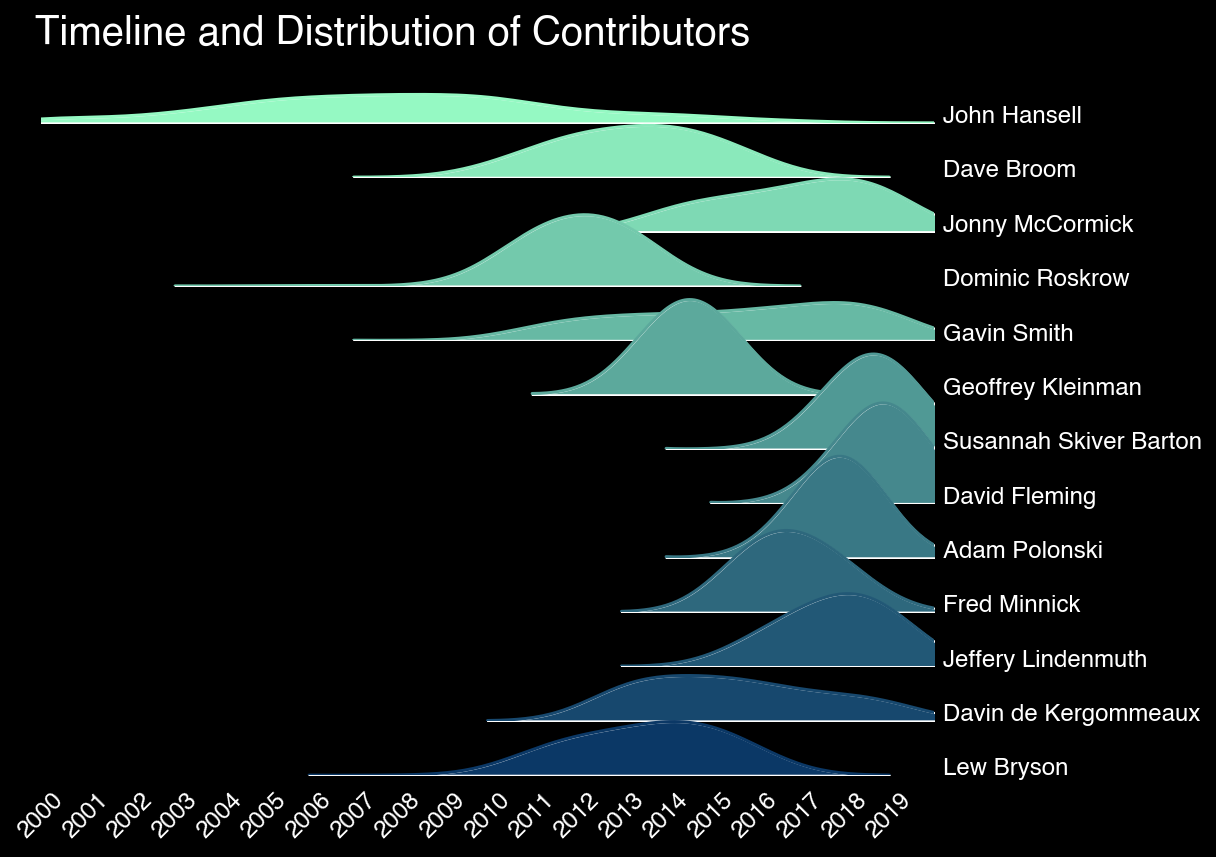

In [13]:
# Reviewer contributions over the years
reviewers = pd.Series(whisky.reviewer.unique())
colors = ['#95F9C3', '#8AE9BB','#7ED9B4','#73C9AC','#67B9A4','#5CA99C',
          '#509995','#45888D','#397885', '#2E687D','#225876',
          '#17486e','#0b3866'
         ]

gs = grid_spec.GridSpec(len(reviewers),1)
fig = plt.figure(figsize=(8,7))

i = 0

ax_objs = []
for reviewer in reviewers:
    reviewer = reviewers[i]
    x = np.array(years_filtered[years_filtered.reviewer == reviewer].year)

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    sns.kdeplot(x, bw=1, shade=True, alpha=1, color=colors[i], ax=ax_objs[-1])

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(2000,2020)
    ax_objs[-1].set_ylim(0,.4)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == len(reviewers)-1:
        ax_objs[-1].set_xlabel("", fontsize=16,fontweight="bold")
        ax_objs[-1].set_xticks(sorted(years_filtered.year.unique()))
        ax_objs[-1].set_xticklabels([i for i in sorted(years_filtered.year.unique())], 
                                    fontsize=12, rotation=45)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    #adj_reviewers = reviewer.replace(" ","\n")
    ax_objs[-1].text(2020.2,0,reviewers[i],fontsize=12,ha="left")


    i += 1

gs.update(hspace=-0.5)

fig.text(0.12,0.85,"Timeline and Distribution of Contributors",fontsize=20)

plt.tight_layout()
plt.show();

Above we can see that the graph clarifies a few things from the previous two graphs. John Hansell has the most reviews because he is the longest tenured writer and most steady in output over the years. Also, you can see the gradual interest in whisky increase as more people are hired to write after 2010.

In [16]:
whisky.head()

rating                                              label  \
0      97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1      97        Bowmore 46 year old (distilled 1964), 42.9%   
2      97                     Johnnie Walker Blue Label, 40%   
3      96    Glenlivet Cellar Collection 1969 vintage, 50.8%   
4      96  The Macallan 29 year old 1976 Vintage (Cask #1...   

             subcategory category  \
0     Single Malt Scotch   Scotch   
1     Single Malt Scotch   Scotch   
2  Blended Scotch Whisky   Scotch   
3     Single Malt Scotch   Scotch   
4     Single Malt Scotch   Scotch   

                                              review         reviewer  year  \
0  What impresses me most is how this whisky evol...     John Hansell  2008   
1  There have been some legendary Bowmores from t...       Dave Broom  2012   
2  Magnificently powerful and intense. Caramels, ...  Jonny McCormick  2018   
3  It’s great that Glenlivet releases whiskies un...     John Hansell  2007   
4  Classic sherry cask-aged Macallan. Antique amb...     John Hansell  2008   

    abv     price   age  vintage  
0 40.50  4,500.00    42     1964  
1 42.90 13,500.00    46     1964  
2 40.00    225.00  <NA>     <NA>  
3 50.80    750.00  <NA>     1969  
4 45.40  1,500.00    29     1976

### Linear Regression

Let's take a deeper dive into a subset of our data to see relationships between variables

In [17]:
whisky.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5208 entries, 0 to 5207
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       5208 non-null   int64  
 1   label        5208 non-null   object 
 2   subcategory  5208 non-null   object 
 3   category     5208 non-null   object 
 4   review       5208 non-null   object 
 5   reviewer     5208 non-null   object 
 6   year         5208 non-null   Int64  
 7   abv          5182 non-null   float64
 8   price        5208 non-null   float64
 9   age          1954 non-null   Int64  
 10  vintage      1164 non-null   Int64  
dtypes: Int64(3), float64(2), int64(1), object(5)
memory usage: 503.5+ KB


In [18]:
whisky_age = whisky.copy()
whisky_age = whisky_age[['rating', 'label', 'abv','price','age']]

In [19]:
whisky_age.dropna(inplace=True)
whisky_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 5202
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  1946 non-null   int64  
 1   label   1946 non-null   object 
 2   abv     1946 non-null   float64
 3   price   1946 non-null   float64
 4   age     1946 non-null   Int64  
dtypes: Int64(1), float64(2), int64(1), object(1)
memory usage: 93.1+ KB


In [20]:
# Winsorizing large outliers for price and age
whisky_age['price_winz'] = winsorize(whisky_age.price, (0,0.15))
whisky_age['age_winz'] = winsorize(whisky_age.age, (0,0.1))

In [21]:
whisky_age['age_winz']= pd.to_numeric(whisky_age.age_winz)

In [22]:
whisky_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 5202
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rating      1946 non-null   int64  
 1   label       1946 non-null   object 
 2   abv         1946 non-null   float64
 3   price       1946 non-null   float64
 4   age         1946 non-null   Int64  
 5   price_winz  1946 non-null   float64
 6   age_winz    1946 non-null   int64  
dtypes: Int64(1), float64(3), int64(2), object(1)
memory usage: 123.5+ KB


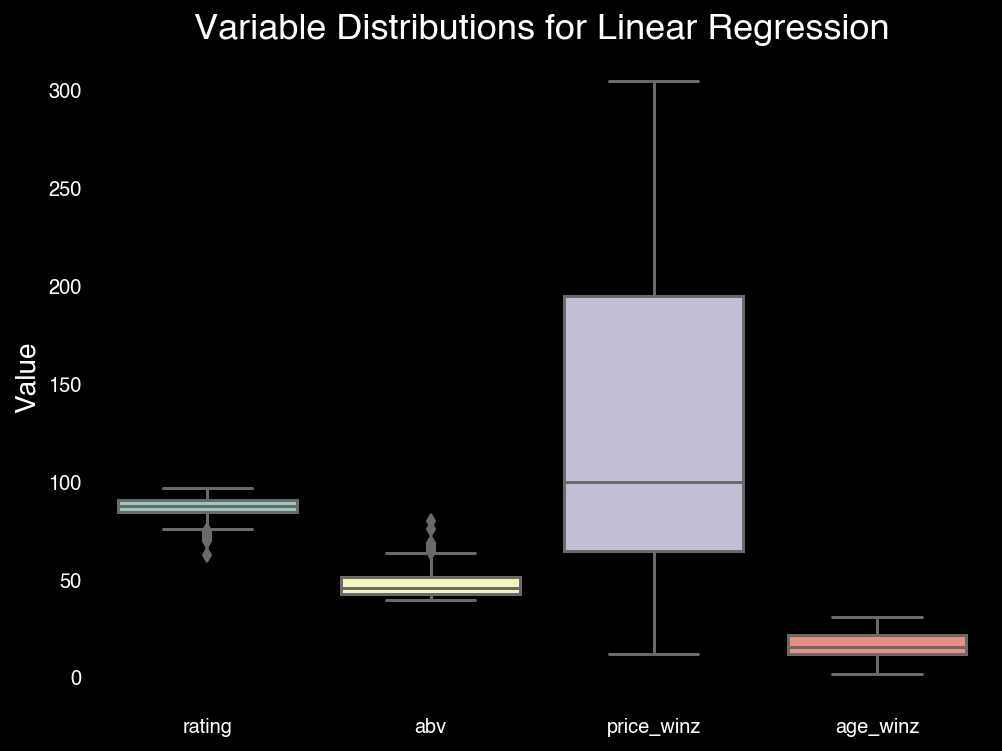

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='variable', y='value', data=pd.melt(whisky_age[['rating','abv','price_winz','age_winz']]))
ax.set_title('Variable Distributions for Linear Regression', fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('Value', fontsize=14)
for i in ['top','bottom','right','left']:
    ax.spines[i].set_visible(False)

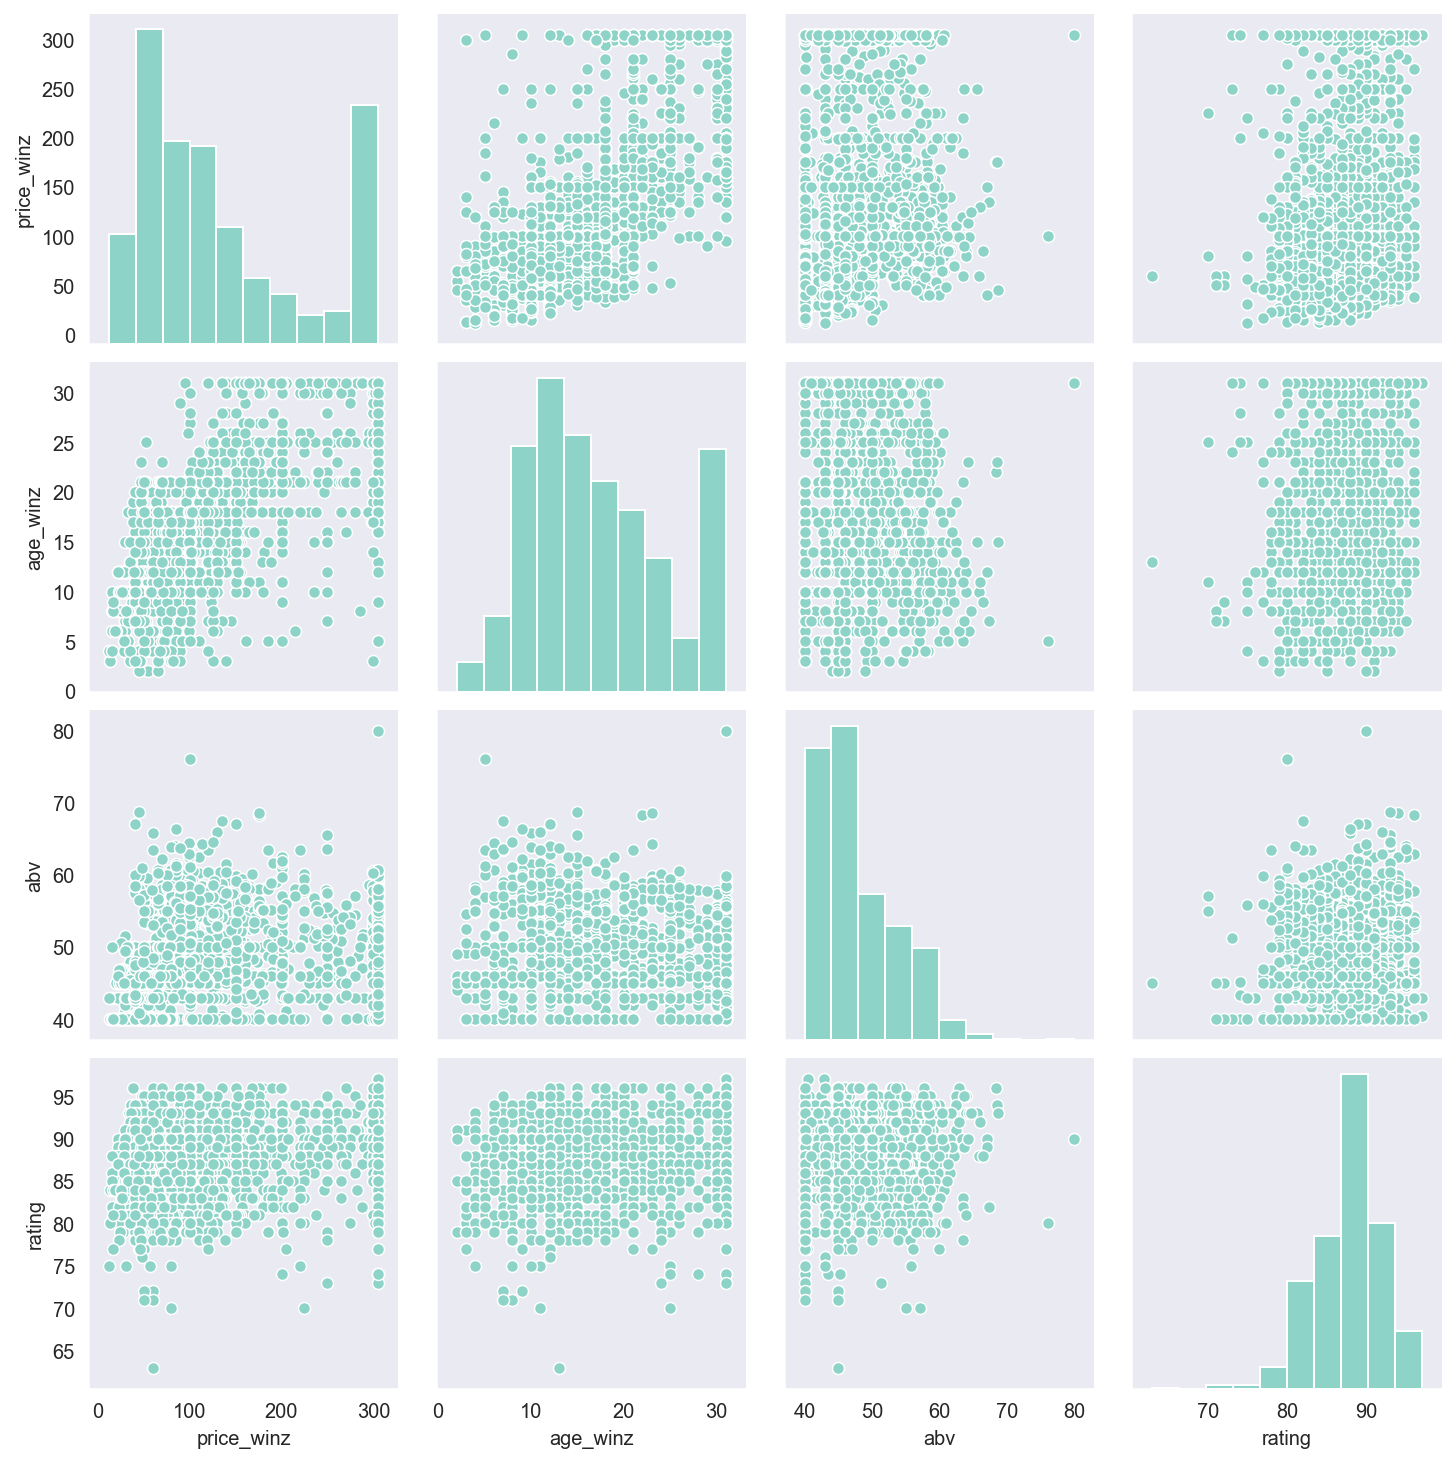

In [24]:
sns.set_style('dark')
sns.pairplot(whisky_age[['price_winz','age_winz','abv','rating']]);

In [25]:
whisky_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 5202
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rating      1946 non-null   int64  
 1   label       1946 non-null   object 
 2   abv         1946 non-null   float64
 3   price       1946 non-null   float64
 4   age         1946 non-null   Int64  
 5   price_winz  1946 non-null   float64
 6   age_winz    1946 non-null   int64  
dtypes: Int64(1), float64(3), int64(2), object(1)
memory usage: 203.5+ KB


In [26]:
# linear regression between age and price
X = whisky_age[['age_winz','abv']]
y = whisky_age['price_winz']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=22)

X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())



                            OLS Regression Results                            
Dep. Variable:             price_winz   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1343.
Date:                Thu, 25 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:22:32   Log-Likelihood:                -8444.0
No. Observations:                1556   AIC:                         1.689e+04
Df Residuals:                    1553   BIC:                         1.691e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -164.7945     11.625    -14.176      0.0

Here we see that age and abv do have an affect on price. (Rating was not included since it is given to the whisky after it is already brought to the market, therefore it would not have an affect on price)

For every year the whisky stays in the barrel, the price for whisky increases by \$9.40

For every percent increase of ABV, the price increases by \$2.89

The constant even tells an interesting story. If the age of the corn liquour and the ABV are both 0, then the price would be -\$164.79. And I don't know about you, but you couldn't pay me to drink non-alcoholic corn liqour that's been quickly passed through a barrell.

Now let's take a look at these variables affect on the rating

In [27]:
X = whisky_age[['age_winz','abv','price']]
y = whisky_age['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=22)

X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     30.78
Date:                Thu, 25 Jun 2020   Prob (F-statistic):           2.52e-19
Time:                        15:22:32   Log-Likelihood:                -4426.0
No. Observations:                1556   AIC:                             8860.
Df Residuals:                    1552   BIC:                             8881.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.3477      0.879     93.656      0.0

Here we can see that while there are siginificant findings with age and abv, they have very little affect on the rating of the whisky (as should be the case since the rating should be based on taste alone). 

# NLP
---

This brings us to natural language processing (or NLP). We will be diving into the reviews and processing them to find more information on these whiskies.

In [28]:
whisky.head()

rating                                              label  \
0      97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1      97        Bowmore 46 year old (distilled 1964), 42.9%   
2      97                     Johnnie Walker Blue Label, 40%   
3      96    Glenlivet Cellar Collection 1969 vintage, 50.8%   
4      96  The Macallan 29 year old 1976 Vintage (Cask #1...   

             subcategory category  \
0     Single Malt Scotch   Scotch   
1     Single Malt Scotch   Scotch   
2  Blended Scotch Whisky   Scotch   
3     Single Malt Scotch   Scotch   
4     Single Malt Scotch   Scotch   

                                              review         reviewer  year  \
0  What impresses me most is how this whisky evol...     John Hansell  2008   
1  There have been some legendary Bowmores from t...       Dave Broom  2012   
2  Magnificently powerful and intense. Caramels, ...  Jonny McCormick  2018   
3  It’s great that Glenlivet releases whiskies un...     John Hansell  2007   
4  Classic sherry cask-aged Macallan. Antique amb...     John Hansell  2008   

    abv     price   age  vintage  
0 40.50  4,500.00    42     1964  
1 42.90 13,500.00    46     1964  
2 40.00    225.00  <NA>     <NA>  
3 50.80    750.00  <NA>     1969  
4 45.40  1,500.00    29     1976

In [29]:
# Creating a variable with all of the relevant words regarding each whisky
whisky['text_for_unigram'] = whisky['review']
whisky['text_for_bigram'] = whisky['label'] + " " + whisky['review'] + " " + whisky['category'] + " " + whisky['subcategory']

In [30]:
whisky.head()

rating                                              label  \
0      97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1      97        Bowmore 46 year old (distilled 1964), 42.9%   
2      97                     Johnnie Walker Blue Label, 40%   
3      96    Glenlivet Cellar Collection 1969 vintage, 50.8%   
4      96  The Macallan 29 year old 1976 Vintage (Cask #1...   

             subcategory category  \
0     Single Malt Scotch   Scotch   
1     Single Malt Scotch   Scotch   
2  Blended Scotch Whisky   Scotch   
3     Single Malt Scotch   Scotch   
4     Single Malt Scotch   Scotch   

                                              review         reviewer  year  \
0  What impresses me most is how this whisky evol...     John Hansell  2008   
1  There have been some legendary Bowmores from t...       Dave Broom  2012   
2  Magnificently powerful and intense. Caramels, ...  Jonny McCormick  2018   
3  It’s great that Glenlivet releases whiskies un...     John Hansell  2007   
4  Classic sherry cask-aged Macallan. Antique amb...     John Hansell  2008   

    abv     price   age  vintage  \
0 40.50  4,500.00    42     1964   
1 42.90 13,500.00    46     1964   
2 40.00    225.00  <NA>     <NA>   
3 50.80    750.00  <NA>     1969   
4 45.40  1,500.00    29     1976   

                                    text_for_unigram  \
0  What impresses me most is how this whisky evol...   
1  There have been some legendary Bowmores from t...   
2  Magnificently powerful and intense. Caramels, ...   
3  It’s great that Glenlivet releases whiskies un...   
4  Classic sherry cask-aged Macallan. Antique amb...   

                                     text_for_bigram  
0  Black Bowmore 42 year old 1964 vintage, 40.5% ...  
1  Bowmore 46 year old (distilled 1964), 42.9% Th...  
2  Johnnie Walker Blue Label, 40% Magnificently p...  
3  Glenlivet Cellar Collection 1969 vintage, 50.8...  
4  The Macallan 29 year old 1976 Vintage (Cask #1...

In [31]:
# NLP processing, stemming
# creating a list of extra stop words to filter out and help differentiate the articles
whisky_words = ['whisky','whiskey','whiski','notes','note','nose','palat','palate','finish','flavor', 'old']

In [32]:
stop_words = stopwords.words('english')
stop_words.extend(whisky_words)
stemmer = SnowballStemmer("english")

In [33]:
TAGS = re.compile('<.*?>')
PUNCT = re.compile("([.;:!\'?\"()\[\]])|(\-)|(\/)|(\\n)|(\\r)|(\*)")
COMMA = re.compile('([,])')
CUSTOM_STOPS = re.compile(r"\b(" + "|".join(whisky_words) + ")\\W*", re.I)

In [34]:
def formatting(body):
    body = body.lower()
    body = TAGS.sub(' ', body)
    body = PUNCT.sub(' ', body)
    body = COMMA.sub('', body)
    body = CUSTOM_STOPS.sub('', body)
    return body

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


# Tried word_tokenize - also removed numbers
# Tokenize and lemmatize
def bigram_preprocess(text):
    result=[]
    for token in word_tokenize(text): # doesn't remove numbers
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 1:
            result.append(lemmatize_stemming(token))         
    return ' '.join(result)

def unigram_preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) : #removes numbers too
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >= 3:
            result.append(lemmatize_stemming(token))         
    return ' '.join(result)

In [35]:
test = whisky.text_for_unigram[3]
test

"It’s great that Glenlivet releases whiskies under the 'Cellar Collection' label. It really shows the true potential of Glenlivet. This bottling is classic ultra-matured Glenlivet, and rivals the 1959 vintage Cellar Collection as the best one ever. An incredibly complex whisky, with notes of vanilla, ripe barley, coconut, and caramel. All this is accentuated by glazed orange, hazelnut, and a potpourri of dried spices. Not the least bit tired for such an aged whisky. (Only 800 bottles for the U.S.)"

In [36]:
test = formatting(test)
test

'it’s great that glenlivet releases es under the  cellar collection  label  it really shows the true potential of glenlivet  this bottling is classic ultra matured glenlivet and rivals the 1959 vintage cellar collection as the best one ever  an incredibly complex with of vanilla ripe barley coconut and caramel  all this is accentuated by glazed orange hazelnut and a potpourri of dried spices  not the least bit tired for such an aged only 800 bottles for the u s  '

In [37]:
# here we are keeping the numbers in the bigram processing to pull out whisky ages like "10 year" and "18 year"
test = bigram_preprocess(test)
test

'great glenlivet releas es cellar collect label show true potenti glenlivet bottl classic ultra matur glenlivet rival 1959 vintag cellar collect best incred complex vanilla ripe barley coconut caramel accentu glaze orang hazelnut potpourri dri spice bite tire age 800 bottl'

In [38]:
test = unigram_preprocess(test)
test

'great glenlivet relea cellar collect label true potenti glenlivet bottl classic ultra matur glenlivet rival vintag cellar collect best incr complex vanilla ripe barley coconut caramel accentu glaze orang hazelnut potpourri dri spice bite tire age bottl'

In [39]:
whisky['text_for_unigram'] = whisky.text_for_unigram.apply(formatting)
whisky['text_for_unigram'] = whisky.text_for_unigram.apply(unigram_preprocess)

whisky['text_for_bigram'] = whisky.text_for_bigram.apply(formatting)
whisky['text_for_bigram'] = whisky.text_for_bigram.apply(bigram_preprocess)


In [40]:
whisky.head()

rating                                              label  \
0      97      Black Bowmore 42 year old 1964 vintage, 40.5%   
1      97        Bowmore 46 year old (distilled 1964), 42.9%   
2      97                     Johnnie Walker Blue Label, 40%   
3      96    Glenlivet Cellar Collection 1969 vintage, 50.8%   
4      96  The Macallan 29 year old 1976 Vintage (Cask #1...   

             subcategory category  \
0     Single Malt Scotch   Scotch   
1     Single Malt Scotch   Scotch   
2  Blended Scotch Whisky   Scotch   
3     Single Malt Scotch   Scotch   
4     Single Malt Scotch   Scotch   

                                              review         reviewer  year  \
0  What impresses me most is how this whisky evol...     John Hansell  2008   
1  There have been some legendary Bowmores from t...       Dave Broom  2012   
2  Magnificently powerful and intense. Caramels, ...  Jonny McCormick  2018   
3  It’s great that Glenlivet releases whiskies un...     John Hansell  2007   
4  Classic sherry cask-aged Macallan. Antique amb...     John Hansell  2008   

    abv     price   age  vintage  \
0 40.50  4,500.00    42     1964   
1 42.90 13,500.00    46     1964   
2 40.00    225.00  <NA>     <NA>   
3 50.80    750.00  <NA>     1969   
4 45.40  1,500.00    29     1976   

                                    text_for_unigram  \
0  impress evolv incred complex viscous sticki to...   
1  legendari bowmor mid bite equal share remark a...   
2  magnific power intens caramel dri peat eleg ci...   
3  great glenlivet releas cellar collect label sh...   
4  classic sherri cask age macallan antiqu amber ...   

                                     text_for_bigram  
0  black bowmor 42 year 1964 vintag 40 impress ev...  
1  bowmor 46 year distil 1964 42 legendari bowmor...  
2  johnni walker blue label 40 magnific power int...  
3  glenlivet cellar collect 1969 vintag 50 great ...  
4  macallan 29 year 1976 vintag cask 11354 45 cla...

Let's take a look at the most common words 

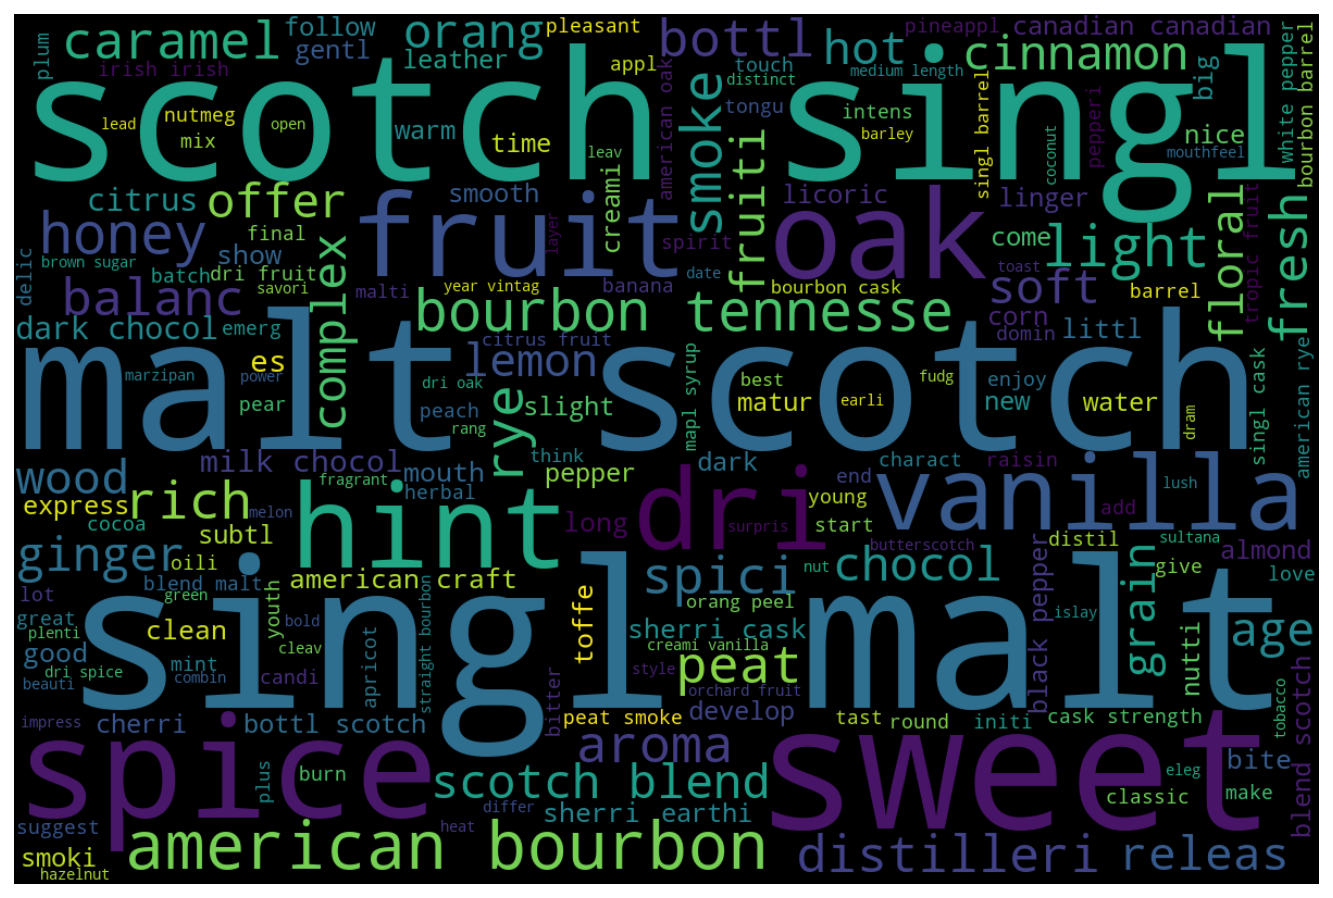

In [41]:
# word cloud
stopwords = set(STOPWORDS)
stopwords.update(["drink", "whiskey",'whisky','whiskey','whiski',
                  'notes','note','nose','palat','palate','finish','flavor', 'year old', 'year','old'])

text = " ".join(review for review in whisky.text_for_bigram)

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1200, height=800, stopwords=stopwords).generate(text)

# Display the generated image:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Important words to note:
* singl malt
* malt scotch
* Sweet
* oak
* spice
* cinnamon
* honey
* malt
* smoke
* caramel
* vanilla
* fruit
* ginger


In [239]:
# Bottom and top 10% of ratings
top10pct = whisky[['rating','text_for_unigram']].sort_values(by='rating', axis=0, ascending=False).iloc[:500]
bottom10pct = whisky[['rating','text_for_unigram']].sort_values(by='rating', axis=0, ascending=True).iloc[:500]

In [240]:
cv = CountVectorizer()
cv_fit=cv.fit_transform(top10pct.text_for_unigram)

top_top10_words = pd.DataFrame(np.asarray(cv_fit.sum(axis=0)), columns=cv.get_feature_names()).T

top = top_top10_words.sort_values(by=0, axis=0, ascending=False).iloc[:20]

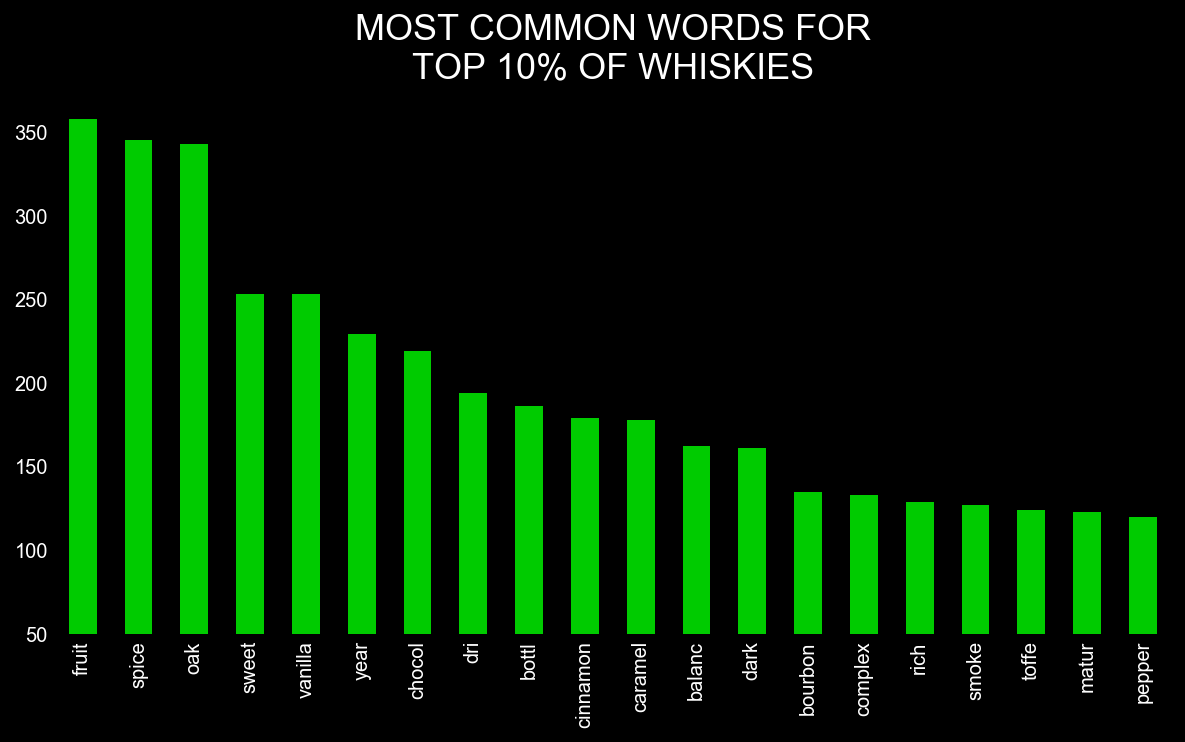

In [247]:
# Of the whiskies rated in the top 10%, these are the most common words
sns.set_style('dark')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10,5))
top.plot(kind='bar', color='lime', alpha=.8, linewidth=0, legend=False, ax=ax)
plt.title("MOST COMMON WORDS FOR\nTOP 10% OF WHISKIES", fontsize=18)
plt.ylim(50,375)
for i in ['top','bottom','right','left']:
    ax.spines[i].set_visible(False);

In [242]:
cv_fit=cv.fit_transform(bottom10pct.text_for_unigram)

top_bottom10_words = pd.DataFrame(np.asarray(cv_fit.sum(axis=0)), columns=cv.get_feature_names()).T

bottom = top_bottom10_words.sort_values(by=0, axis=0, ascending=False).iloc[:20]

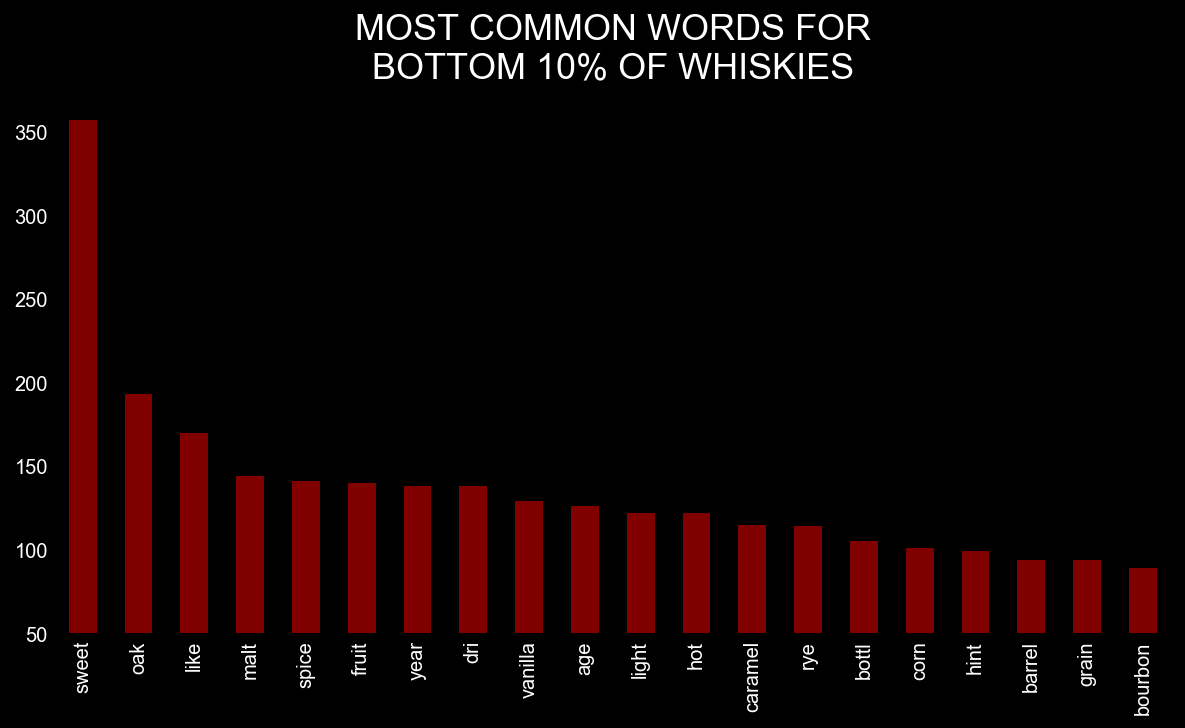

In [248]:
fig, ax = plt.subplots(figsize=(10,5))
bottom.plot(kind='bar', color='maroon', linewidth=0, legend=False, ax=ax)
plt.title("MOST COMMON WORDS FOR\nBOTTOM 10% OF WHISKIES", fontsize=18)
plt.ylim(50,375)
for i in ['top','bottom','right','left']:
    ax.spines[i].set_visible(False);

## Vectorization
___

In order to process the bigrams and unigrams in a ML model, we need to turn them into a sparse matrix via vectorization. 

In [47]:
# Bigram TFIDF
stop_words.extend(['old'])
bigram_vec = TfidfVectorizer(stop_words=stop_words, max_df=.7, 
                               min_df=.01, ngram_range=(2,2), max_features=3000)

# fit / transform
bigram_fitted_vectorizer=bigram_vec.fit(whisky.text_for_bigram)
bigram_tfidf_vectors=bigram_fitted_vectorizer.transform(whisky.text_for_bigram)

# to data frame with words as columns
bigram_tfidf = pd.DataFrame(bigram_tfidf_vectors.toarray(), columns=bigram_vec.get_feature_names())

bigram_tfidf.head()

10 year  11 year  12 year  13 year  14 year  15 year  16 year  17 year  \
0     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
1     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
2     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
3     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
4     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   

   18 year  20 year  ...  year 40  year 43  year 45  year 46  year 50  \
0     0.00     0.00  ...     0.00     0.00     0.00     0.00     0.00   
1     0.00     0.00  ...     0.00     0.00     0.00     0.00     0.00   
2     0.00     0.00  ...     0.00     0.00     0.00     0.00     0.00   
3     0.00     0.00  ...     0.00     0.00     0.00     0.00     0.00   
4     0.00     0.00  ...     0.00     0.00     0.00     0.00     0.00   

   year age  year bourbon  year cask  year express  year singl  
0      0.00          0.00       0.00          0.00        0.00  
1      0.00          0.00       0.00          0.00        0.00  
2      0.00          0.00       0.00          0.00        0.00  
3      0.00          0.00       0.00          0.00        0.00  
4      0.00          0.00       0.00          0.00        0.00  

[5 rows x 190 columns]

In [249]:
# Just verifying that not every bigram has the word "year"
bigram_tfidf.iloc[0:5,80:100]

gold color  golden raisin  gordon macphail  green appl  highland park  \
0        0.00           0.00             0.00        0.00           0.00   
1        0.00           0.00             0.00        0.00           0.00   
2        0.00           0.00             0.00        0.00           0.00   
3        0.00           0.00             0.00        0.00           0.00   
4        0.00           0.00             0.00        0.00           0.00   

   hint smoke  honey malt  honey vanilla  ice cream  ice sugar  ice tea  \
0        0.00        0.00           0.00       0.00       0.00     0.00   
1        0.00        0.00           0.00       0.00       0.00     0.00   
2        0.00        0.00           0.00       0.00       0.00     0.00   
3        0.00        0.00           0.00       0.00       0.00     0.00   
4        0.00        0.00           0.00       0.00       0.00     0.00   

   irish blend  irish irish  irish singl  jaffa orang  japanes japanes  \
0         0.00         0.00         0.00         0.00             0.00   
1         0.00         0.00         0.00         0.00             0.00   
2         0.00         0.00         0.00         0.00             0.00   
3         0.00         0.00         0.00         0.00             0.00   
4         0.00         0.00         0.00         0.00             0.00   

   kentucki straight  limit edit  long spici  malt american  
0               0.00        0.00        0.00           0.00  
1               0.00        0.00        0.00           0.00  
2               0.00        0.00        0.00           0.00  
3               0.00        0.00        0.00           0.00  
4               0.00        0.00        0.00           0.00

In [48]:
# Unigram TFIDF
unigram_vec = TfidfVectorizer(stop_words=stop_words, max_df=.7, 
                                min_df=.01, ngram_range=(1,1), max_features=3000)

# fit / transform
unigram_fitted_vectorizer=unigram_vec.fit(whisky.text_for_unigram)
unigram_tfidf_vectors=unigram_fitted_vectorizer.transform(whisky.text_for_unigram)

# to data frame with words as columns
unigram_tfidf = pd.DataFrame(unigram_tfidf_vectors.toarray(), columns=unigram_vec.get_feature_names())

unigram_tfidf.head()

acid  add  addit  age  alcohol  allow  allspic  almond  alongsid  amber  \
0  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
1  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
2  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
3  0.00 0.00   0.00 0.15     0.00   0.00     0.00    0.00      0.00   0.00   
4  0.00 0.00   0.00 0.16     0.00   0.00     0.00    0.00      0.00   0.27   

   ...  work  world  wrap  year  yield  young  younger  youth  zest  zesti  
0  ...  0.00   0.00  0.00  0.00   0.00   0.00     0.00   0.00  0.00   0.00  
1  ...  0.00   0.00  0.00  0.00   0.00   0.00     0.00   0.00  0.00   0.00  
2  ...  0.00   0.00  0.00  0.00   0.00   0.00     0.00   0.00  0.00   0.00  
3  ...  0.00   0.00  0.00  0.00   0.00   0.00     0.00   0.00  0.00   0.00  
4  ...  0.00   0.00  0.00  0.00   0.00   0.00     0.00   0.00  0.00   0.00  

[5 rows x 643 columns]

In [49]:
# Join TFIDFS together
whisky_tfidf = unigram_tfidf.join(bigram_tfidf)
whisky_tfidf.head()

acid  add  addit  age  alcohol  allow  allspic  almond  alongsid  amber  \
0  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
1  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
2  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
3  0.00 0.00   0.00 0.15     0.00   0.00     0.00    0.00      0.00   0.00   
4  0.00 0.00   0.00 0.16     0.00   0.00     0.00    0.00      0.00   0.27   

   ...  year 40  year 43  year 45  year 46  year 50  year age  year bourbon  \
0  ...     0.00     0.00     0.00     0.00     0.00      0.00          0.00   
1  ...     0.00     0.00     0.00     0.00     0.00      0.00          0.00   
2  ...     0.00     0.00     0.00     0.00     0.00      0.00          0.00   
3  ...     0.00     0.00     0.00     0.00     0.00      0.00          0.00   
4  ...     0.00     0.00     0.00     0.00     0.00      0.00          0.00   

   year cask  year express  year singl  
0       0.00          0.00        0.00  
1       0.00          0.00        0.00  
2       0.00          0.00        0.00  
3       0.00          0.00        0.00  
4       0.00          0.00        0.00  

[5 rows x 833 columns]

In [50]:
# We we use decomposition methods in the next section, pulling out the top 10 words for each observation
# may be helpful in seeing patterns
top_tens=[]
for i in range(whisky_tfidf.shape[0]):
    row = whisky_tfidf.iloc[i]
    top_tens.append(" ".join(list(row[row>0].sort_values(ascending=False)[:10].index)))

whisky_tfidf['tfidf_top_tens'] = pd.Series(top_tens)

In [51]:
whisky_tfidf.head()

acid  add  addit  age  alcohol  allow  allspic  almond  alongsid  amber  \
0  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
1  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
2  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
3  0.00 0.00   0.00 0.15     0.00   0.00     0.00    0.00      0.00   0.00   
4  0.00 0.00   0.00 0.16     0.00   0.00     0.00    0.00      0.00   0.27   

   ...  year 43  year 45  year 46  year 50  year age  year bourbon  year cask  \
0  ...     0.00     0.00     0.00     0.00      0.00          0.00       0.00   
1  ...     0.00     0.00     0.00     0.00      0.00          0.00       0.00   
2  ...     0.00     0.00     0.00     0.00      0.00          0.00       0.00   
3  ...     0.00     0.00     0.00     0.00      0.00          0.00       0.00   
4  ...     0.00     0.00     0.00     0.00      0.00          0.00       0.00   

   year express  year singl                                     tfidf_top_tens  
0          0.00        0.00  black cherri chocol cover polish leather roast...  
1          0.00        0.00  peat smoke tropic fruit editor scotch singl ch...  
2          0.00        0.00  dri spice blend scotch scotch blend seed smoke...  
3          0.00        0.00  dri spice bottl scotch collect scotch singl ma...  
4          0.00        0.00  spice cinnamon dri spice sherri cask wisp anti...  

[5 rows x 834 columns]

## Decomposition
---

In order to visualize the relationships of the reviews and find any potential clusters, we will use PCA and UMAP for decomposition

In [52]:
X = whisky_tfidf.iloc[:,:-1]

#### PCA

In [53]:
# PCA 3D
pca = PCA(n_components=3, whiten=True, random_state=22).fit_transform(X)

fig = go.Figure(data=[go.Scatter3d(
    x=pca[:,0],
    y=pca[:,1],
    z=pca[:,2],
    mode='markers',
    marker=dict(
        size=3,
        #color=whisky.category, 
        #colorscale='viridis',
    ),
    
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
    

)])

# tight layout
fig.update_layout(height=300,
                  width=300,
                  title_text='PCA',
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      )
                           ),
                  dragmode='orbit'
                 )

fig.show()

#### UMAP

In [54]:
# UMAP visual for X Standardized and predicted LDA overlay
umap_results = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine', 
                         n_components=3, random_state=22).fit_transform(X)

In [55]:
fig = go.Figure(data=[go.Scatter3d(
            x=umap_results[:,0],
            y=umap_results[:,1],
            z=umap_results[:,2],
            mode='markers',
            marker=dict(
                size=3,
                #color=covid_lda.prob_topic, 
                #colorscale='viridis',
            ),
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
        )])

fig.update_layout(height=300,
                  width=300,
                  title_text='UMAP',
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      )
                           ),
                  dragmode='orbit'
                 )
fig.show()

## Unsupervised Learning
___

#### Hierarchical

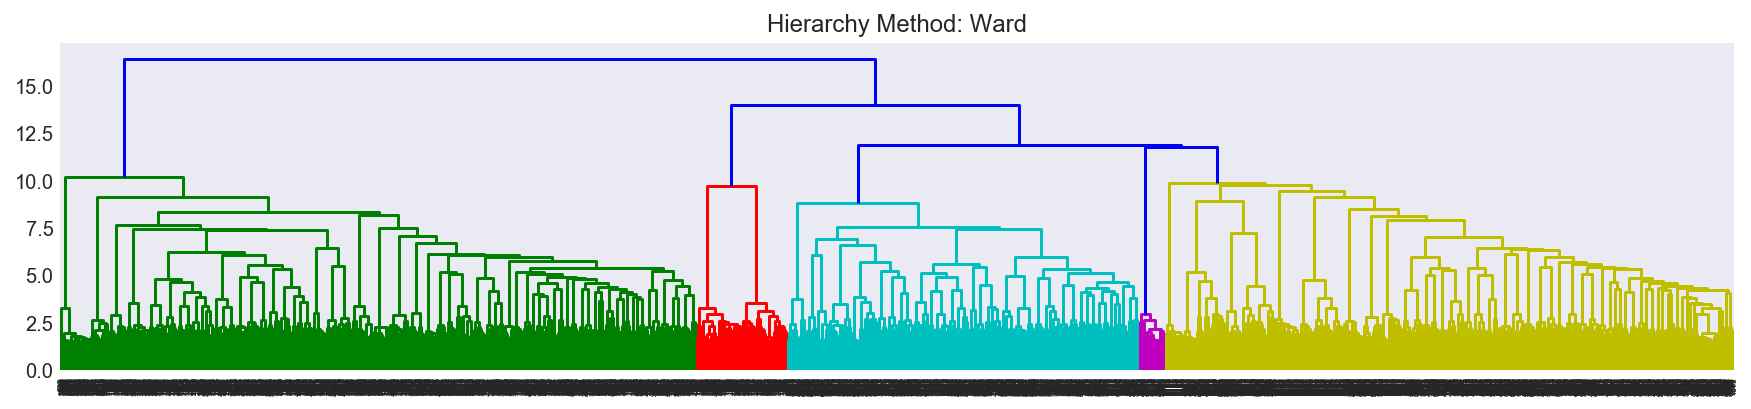

In [56]:
# Hierarchical with X
methods = ['average', 'complete', 'ward'] #all were run, ward looks the best

plt.style.use('seaborn-dark')
plt.figure(figsize=(15,3))
dendrogram(linkage(X, method='ward'))
plt.title(f'Hierarchy Method: Ward')
plt.xticks(fontsize=4)
plt.show()


In [57]:
# heirarchical 
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward') 
# both clusters of 3 and 5 were tested (based on the above graph) and found ineffective400
hier_clusters = cluster.fit_predict(X)


fig = go.Figure(data=[go.Scatter3d(
    x=pca[:,0],
    y=pca[:,1],
    z=pca[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=cluster.labels_, 
        colorscale='Agsunset',
    ),
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
    #hovertext=['{}'.format(i) for i in covid.source],

)])

# tight layout
fig.update_layout(title_text='Hierarchical Clustering with PCA <br>Clusters - Colors</br>',
                  height=300, 
                  width=300,
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 dragmode='orbit',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      ),   
                    )
                )




output = go.FigureWidget(fig)
output

FigureWidget({
    'data': [{'hovertemplate': '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
          …

In [58]:
import hdbscan
# Hierarchical DBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=1, metric='euclidean')
# Metrics l1, l2, euclidean tested
# clusters from 10-60 inspected, none helpful

In [59]:
hdbscan_labels = clusterer.fit(X)

In [60]:
fig = go.Figure(data=[go.Scatter3d(
    x=pca[:,0],
    y=pca[:,1],
    z=pca[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=hdbscan_labels.labels_, 
        colorscale='Agsunset',
    ),
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
    #hovertext=['{}'.format(i) for i in covid.source],

)])

# tight layout
fig.update_layout(title_text='HDBSCAN with PCA <br>Clusters - Colors</br>',
                  height=300, 
                  width=300,
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 dragmode='orbit',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      ),   
                    )
                )




output = go.FigureWidget(fig)
output

FigureWidget({
    'data': [{'hovertemplate': '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
          …

In [61]:
# UMAP with Hierarchical Colors
fig = go.Figure(data=[go.Scatter3d(
    x=umap_results[:,0],
    y=umap_results[:,1],
    z=umap_results[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=cluster.labels_, 
        colorscale='Agsunset',
    ),
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
    #hovertext=['{}'.format(i) for i in covid.source],

)])

# tight layout
fig.update_layout(title_text='Hierarchical Clustering with UMAP <br>Clusters - Colors</br>',
                  height=300, 
                  width=300,
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 dragmode='orbit',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      ),   
                    )
                )




output = go.FigureWidget(fig)
output

FigureWidget({
    'data': [{'hovertemplate': '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
          …

In [62]:
color_cycle = ['maroon', 'gold', 'navy', 'aqua','orange','green','lightgreen','magenta','yellow','purple']

In [63]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
gmm_clusters = gmm.fit_predict(X)

In [64]:
# UMAP with Hierarchical Colors
fig = go.Figure(data=[go.Scatter3d(
    x=umap_results[:,0],
    y=umap_results[:,1],
    z=umap_results[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=[color_cycle[i] for i in gmm_clusters], 
        colorscale='Agsunset',
    ),
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
    #hovertext=['{}'.format(i) for i in covid.source],

)])

# tight layout
fig.update_layout(title_text='GMM Clustering with UMAP <br>Clusters - Colors</br>',
                  height=400, 
                  width=400,
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 dragmode='orbit',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      ),   
                    )
                )




output = go.FigureWidget(fig)
output

FigureWidget({
    'data': [{'hovertemplate': '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
          …

In [65]:
# GMM with PCA
gmm = GaussianMixture(n_components=4, random_state=22)
gmm_clusters = gmm.fit_predict(X)


fig = go.Figure(data=[go.Scatter3d(
    x=pca[:,0],
    y=pca[:,1],
    z=pca[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=[color_cycle[i] for i in gmm_clusters], 
        colorscale='Agsunset',
    ),
    hovertemplate =
    '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
    text = ['{}'.format(i) for i in whisky_tfidf.tfidf_top_tens],
    #hovertext=['{}'.format(i) for i in covid.source],

)])

# tight layout
fig.update_layout(title_text='GMM with PCA <br>Clusters - Colors</br>',
                  height=400, 
                  width=400,
                  margin=dict(l=0, r=0, b=0, t=40),
                 paper_bgcolor='#000000',
                 plot_bgcolor='#000000',
                 dragmode='orbit',
                 scene=dict(xaxis=dict(visible=False,
                                      ),
                            yaxis=dict(visible=False
                                      ),
                            zaxis=dict(visible=False
                                      ),   
                    )
                )




output = go.FigureWidget(fig)
output

FigureWidget({
    'data': [{'hovertemplate': '<b>Main Topics</b>:<br>%{text}</br><extra></extra>',
          …

This is the best separation and color segmentation of any of the models. Will attach cluster assignments to the TFIDF for the modeling stage.

In [66]:
whisky_tfidf['gmm_clusters'] = gmm_clusters

In [67]:
whisky_tfidf.head()

acid  add  addit  age  alcohol  allow  allspic  almond  alongsid  amber  \
0  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
1  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
2  0.00 0.00   0.00 0.00     0.00   0.00     0.00    0.00      0.00   0.00   
3  0.00 0.00   0.00 0.15     0.00   0.00     0.00    0.00      0.00   0.00   
4  0.00 0.00   0.00 0.16     0.00   0.00     0.00    0.00      0.00   0.27   

   ...  year 45  year 46  year 50  year age  year bourbon  year cask  \
0  ...     0.00     0.00     0.00      0.00          0.00       0.00   
1  ...     0.00     0.00     0.00      0.00          0.00       0.00   
2  ...     0.00     0.00     0.00      0.00          0.00       0.00   
3  ...     0.00     0.00     0.00      0.00          0.00       0.00   
4  ...     0.00     0.00     0.00      0.00          0.00       0.00   

   year express  year singl  \
0          0.00        0.00   
1          0.00        0.00   
2          0.00        0.00   
3          0.00        0.00   
4          0.00        0.00   

                                      tfidf_top_tens  gmm_clusters  
0  black cherri chocol cover polish leather roast...             3  
1  peat smoke tropic fruit editor scotch singl ch...             3  
2  dri spice blend scotch scotch blend seed smoke...             1  
3  dri spice bottl scotch collect scotch singl ma...             3  
4  spice cinnamon dri spice sherri cask wisp anti...             3  

[5 rows x 835 columns]

## Supervised Learning
---
Because the main goal of this project is to produce a whisky recommendation system based on user input (and not recommend based on category or on any of the other whiskies), we will not be splitting train and test data as each unique whisky is a class in the classification. 

In order to accomplish this task, I will be using random forest classification algorithm to provide embeddings for each review based on the ngram vectors.

#### Random Forest Classifier Embeddings

In [68]:
X = whisky_tfidf.drop('tfidf_top_tens', axis=1)
# (5208,834)

In [69]:
Y = whisky['label'] #(5208,)

rfc = RandomForestClassifier(n_estimators=40, criterion='gini', n_jobs=-1, random_state=22)
rfc.fit(X,Y)
print('done')

done


Let's take a look at the how the decision trees of the random forest are making their decisions and what attributes they find important.

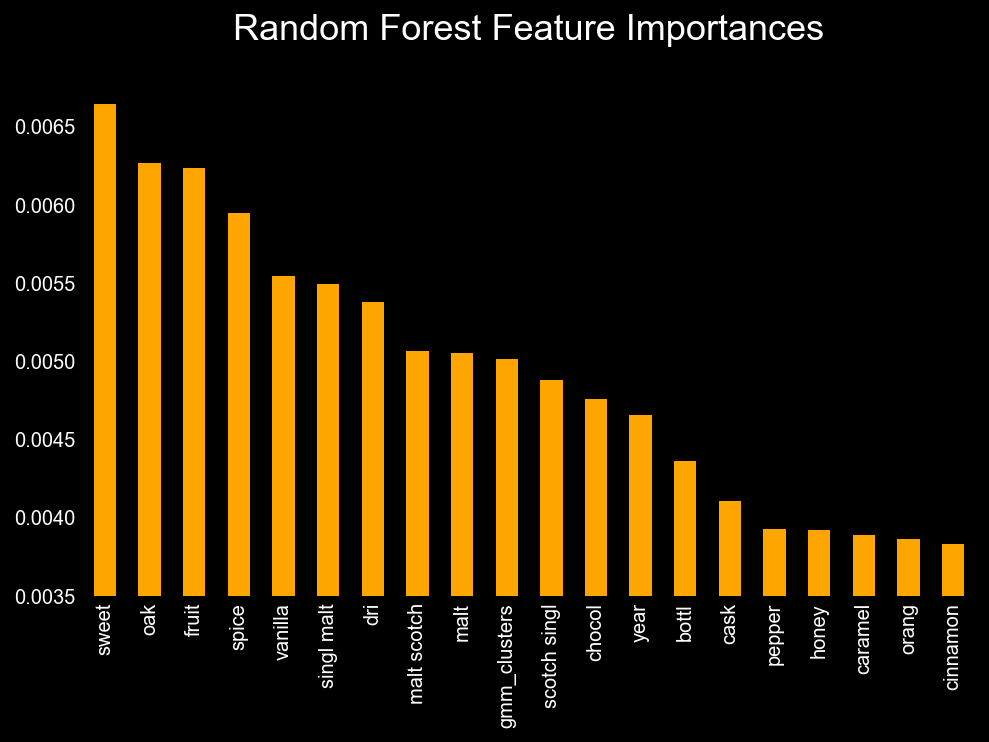

In [71]:
# Random Forest feature importances
plt.style.use('dark_background')
rfc_feat_import = pd.DataFrame(rfc.feature_importances_, index=X.columns).sort_values(by=0, axis=0, ascending=False)[:20]
fig, ax = plt.subplots(figsize=(8,5))

plt.style.use('dark_background')
rfc_feat_import.plot(kind='bar', color='orange', linewidth=0,legend=False, ax=ax)
ax.set_title('Random Forest Feature Importances', fontsize=18)
plt.ylim(.0035,);

Since we cannot perform our typical tests without a train/test, the best way to test random forest embeddings is by reconstruction and self-prediction of a review. If you were to process a review, lemmitize, stem, vectorize, and then use the random forest to predict, will it predict the correct whisky? 

In [250]:
# Duncan Taylor NC2 review
test_input = '''
Pale straw. One of a seemingly never-ending stream of Imperials from 
all of which show remarkable consistency and are rarely over-wooded, 
thereby allowing the distillery character to shine. Here are echoes of Loire Sauvignon Blanc — 
nettles, gooseberry, cut grass, fennel tops, and fresh herbs — 
with a hint of Imperial’s giveaway American cream soda softness. 
The palate is as soft as soy milk. Classic Imperial.'''

test_input = formatting(test_input)
test_input1 = [unigram_preprocess(test_input)]
test_input2 = [bigram_preprocess(test_input)]

print(test_input)
print('\n')
print(test_input1)
print('\n')
print(test_input2)

 pale straw  one of a seemingly never ending stream of imperials from  all of which show remarkable consistency and are rarely over wooded  thereby allowing the distillery character to shine  here are echoes of loire sauvignon blanc —  nettles gooseberry cut grass fennel tops and fresh herbs —  with a hint of imperial’s giveaway american cream soda softness   the e is as soft as soy milk  classic imperial 


['pale straw seem end stream imperi remark consist rare wood allow distilleri charact shine echo loir sauvignon blanc nettl gooseberri cut grass fennel top fresh herb hint imperi giveaway american cream soda soft soft soy milk classic imperi']


['pale straw seem end stream imperi remark consist rare wood allow distilleri charact shine echo loir sauvignon blanc nettl gooseberri cut grass fennel top fresh herb hint imperi giveaway american cream soda soft soft soy milk classic imperi']


In [208]:
# Creating ngram vectors for the user input
test_unigram = unigram_vec.transform(test_input1).toarray()
test_bigram = bigram_vec.transform(test_input2).toarray()
full_grams = np.concatenate([test_unigram, test_bigram], axis=1) # Concatenating them

# GMM prediction of user input
test_gmm = gmm.predict(full_grams).reshape(1,1)
full_test = np.concatenate([full_grams, test_gmm], axis=1) # adding GMMs to the ngrams

# random forest prediction of the full user input
probas = rfc.predict_proba(full_test)
# random forest probabilities with random forest classes and full outer join to original df
top_probas = pd.DataFrame(probas, columns=rfc.classes_).T 
probas_to_whisky = whisky.join(top_probas, on=whisky.label, how='outer')

In [204]:
#probas_to_whisky['subcategory'] = probas_to_whisky['subcategory'].str.lower()
#probas_to_whisky['category'] = probas_to_whisky['category'].str.lower()
#probas_to_whisky.head()
#test_final = probas_to_whisky[probas_to_whisky.subcategory.str.contains('rye')]
#test_final.shape

(230, 15)

In [209]:
# creating top3 list by sorting probability values
top_3_list = probas_to_whisky.sort_values(by=0, axis=0, ascending=False)[:3]

In [210]:
top_3_list

key_0  rating  \
1793  Duncan Taylor NC2 (distilled at Imperial) 1997...      85   
1049      Wemyss Vintage Malt Ginger Compote, 1996, 46%      88   
4709  Chichibu The First distilled 2008 (bottled 201...      81   

                                                  label  \
1793  Duncan Taylor NC2 (distilled at Imperial) 1997...   
1049      Wemyss Vintage Malt Ginger Compote, 1996, 46%   
4709  Chichibu The First distilled 2008 (bottled 201...   

                     subcategory  category  \
1793          Single Malt Scotch    Scotch   
1049  Blended Malt Scotch Whisky    Scotch   
4709             Japanese Whisky  Japanese   

                                                 review    reviewer  year  \
1793  Pale straw. One of a seemingly never-ending st...  Dave Broom  2011   
1049  The Wemyss range — overseen by Susan Colville ...  Dave Broom  2011   
4709  Ichiro Akuto, whose family previously owned th...  Dave Broom  2012   

       abv  price   age  vintage  \
1793   nan  60.00    13     1997   
1049 46.00  84.00  <NA>     1996   
4709 61.80 144.00  <NA>     2008   

                                       text_for_unigram  \
1793  pale straw seem end stream imperi duncan taylo...   
1049  wemyss rang overse susan colvill quiet build d...   
4709  ichiro akuto famili previous own demolish hany...   

                                        text_for_bigram    0  
1793  duncan taylor nc2 distil imperi 1997 13 year p... 0.28  
1049  wemyss vintag malt ginger compot 1996 46 wemys... 0.07  
4709  chichibu distil 2008 bottl 2011 61 ichiro akut... 0.05

SUCCESS! 

In [211]:
def top_3_print(top_3_list):
    for i in top_3_list.label:

        THE_WHISKY = probas_to_whisky[probas_to_whisky.label == str(i)]

        print(' '.join(THE_WHISKY.label.values))
        print('Rating: ' + str(int(THE_WHISKY.rating.values)))
        print(' '.join(THE_WHISKY.subcategory))
        print(' '.join(THE_WHISKY.review))
        print('Price: $' + str(int(THE_WHISKY['price'].values)))
        print('-' * 50 + '\n')

top_3_print(top_3_list)

Duncan Taylor NC2 (distilled at Imperial) 1997 13 year old
Rating: 85
Single Malt Scotch
Pale straw. One of a seemingly never-ending stream of Imperials from Duncan Taylor, all of which show remarkable consistency and are rarely over-wooded, thereby allowing the distillery character to shine. Here are echoes of Loire Sauvignon Blanc — nettles, gooseberry, cut grass, fennel tops, and fresh herbs — with a hint of Imperial’s giveaway American cream soda softness. The palate is as soft as soy milk. Classic Imperial.
Price: $60
--------------------------------------------------

Wemyss Vintage Malt Ginger Compote, 1996, 46%
Rating: 88
Blended Malt Scotch Whisky
The Wemyss range — overseen by Susan Colville — has been quietly building a deserved reputation for being among the most consistently enjoyable single cask bottlings. This new example hails from the mighty Benrinnes distillery, but shows a milder side to its make — there is indeed ginger aplenty, along with cumin, crystallized fruit,

### Extra Trees Classifier Embeddings

In addition to Random Forest Classifier, an Extra Trees Classifier has the ability to work even better on sparse matrix data

In [225]:
X = whisky_tfidf.drop('tfidf_top_tens', axis=1)
# (5208,834)

Y = whisky['label'] #(5208,)

etc = ExtraTreesClassifier(n_estimators=40, n_jobs=-1, random_state=22)
etc.fit(X,Y)
print('done')

done


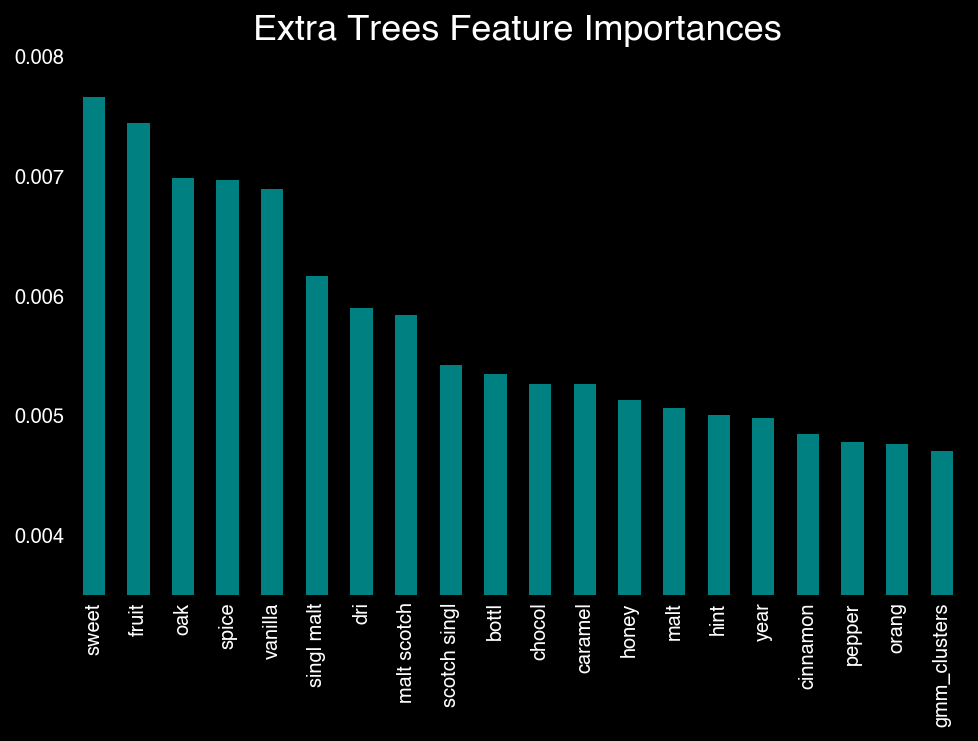

In [227]:
# Random Forest feature importances
plt.style.use('dark_background')
etc_feat_import = pd.DataFrame(etc.feature_importances_, index=X.columns).sort_values(by=0, axis=0, ascending=False)[:20]
fig, ax = plt.subplots(figsize=(8,5))

plt.style.use('dark_background')
etc_feat_import.plot(kind='bar', color='teal', linewidth=0,legend=False, ax=ax)
ax.set_title('Extra Trees Feature Importances', fontsize=18)
plt.ylim(.0035,);

In [228]:
# Duncan Taylor NC2 review
etc_test_input = '''
Pale straw. One of a seemingly never-ending stream of Imperials from 
all of which show remarkable consistency and are rarely over-wooded, 
thereby allowing the distillery character to shine. Here are echoes of Loire Sauvignon Blanc — 
nettles, gooseberry, cut grass, fennel tops, and fresh herbs — 
with a hint of Imperial’s giveaway American cream soda softness. 
The palate is as soft as soy milk. Classic Imperial.'''

etc_test_input = formatting(test_input)
etc_test_input1 = [unigram_preprocess(test_input)]
etc_test_input2 = [bigram_preprocess(test_input)]

print(test_input)
print('\n')
print(test_input1)
print('\n')
print(test_input2)

 pale straw  one of a seemingly never ending stream of imperials from  all of which show remarkable consistency and are rarely over wooded  thereby allowing the distillery character to shine  here are echoes of loire sauvignon blanc —  nettles gooseberry cut grass fennel tops and fresh herbs —  with a hint of imperial’s giveaway american cream soda softness   the e is as soft as soy milk  classic imperial 


['pale straw seem end stream imperi remark consist rare wood allow distilleri charact shine echo loir sauvignon blanc nettl gooseberri cut grass fennel top fresh herb hint imperi giveaway american cream soda soft soft soy milk classic imperi']


['pale straw seem end stream imperi remark consist rare wood allow distilleri charact shine echo loir sauvignon blanc nettl gooseberri cut grass fennel top fresh herb hint imperi giveaway american cream soda soft soft soy milk classic imperi']


In [229]:
# Creating ngram vectors for the user input
etc_test_unigram = unigram_vec.transform(etc_test_input1).toarray()
etc_test_bigram = bigram_vec.transform(etc_test_input2).toarray()
etc_full_grams = np.concatenate([etc_test_unigram, etc_test_bigram], axis=1) # Concatenating them

# GMM prediction
etc_test_gmm = gmm.predict(etc_full_grams).reshape(1,1)
etc_full_test = np.concatenate([etc_full_grams, etc_test_gmm], axis=1) # adding GMMs to the ngrams

# etc forest prediction of the full user input
etc_probas = etc.predict_proba(etc_full_test)
# etc forest probabilities with etc forest classes and full outer join to original df
etc_top_probas = pd.DataFrame(etc_probas, columns=etc.classes_).T 
etc_probas_to_whisky = whisky.join(etc_top_probas, on=whisky.label, how='outer')

In [231]:
# creating top3 list by sorting probability values
etc_top_3_list = etc_probas_to_whisky.sort_values(by=0, axis=0, ascending=False)[:3]

In [232]:
top_3_print(etc_top_3_list)

Duncan Taylor NC2 (distilled at Imperial) 1997 13 year old
Rating: 85
Single Malt Scotch
Pale straw. One of a seemingly never-ending stream of Imperials from Duncan Taylor, all of which show remarkable consistency and are rarely over-wooded, thereby allowing the distillery character to shine. Here are echoes of Loire Sauvignon Blanc — nettles, gooseberry, cut grass, fennel tops, and fresh herbs — with a hint of Imperial’s giveaway American cream soda softness. The palate is as soft as soy milk. Classic Imperial.
Price: $60
--------------------------------------------------

Tullibardine, 1992 Vintage, 46%
Rating: 82
Single Malt Scotch
Fresh and clean, with notes of creamy barley, cut grass, coconut marshmallow, pencil shavings, and oatcake. Soft finish. Subtle spice dances about in the background. Bottling at 46% adds to the richness. A soothing whisky. 

Price: $50
--------------------------------------------------

Canadian Club Whisky, 40%
Rating: 80
Canadian
Pale, almost peach colo

## Word2Vec
---
<br></br>
Word to vec is a shallow, 2-layer neural network that creates embeddings for each item passed in based on a specified window of its surrounding items.

### Word2Vec as a predictor

In [106]:
# Separating the reviews to create embeddings per review
sentences = [row.split(',') for row in whisky.text_for_bigram]

In [107]:
sentences[:5]

[['black bowmor 42 year 1964 vintag 40 impress evolv incred complex viscous sticki toffe earthi oak fig cake roast nut fall fruit pancak batter black cherri ripe peach dark chocol cover espresso bean polish leather tobacco hint wild game linger leafi damp kiln smoke continu long swallow hope dream er scotch singl malt scotch'],
 ['bowmor 46 year distil 1964 42 legendari bowmor mid 60s bite equal share remark aroma tropic fruit move hallucinatori intens guava mango peach pineappl grapefruit light touch peat smoke memori islay realiti concentr low strength silki headi haunt last forev dri glass legend bear bottl editor choic scotch singl malt scotch'],
 ['johnni walker blue label 40 magnific power intens caramel dri peat eleg cigar smoke seed scrap vanilla bean brand new pencil peppercorn coriand seed star anis deepli satisfi nose experi silki caramel bounti fruit ripe peach stew appl orang pith pervas smoke element burn tobacco abid smoke dri spice banoffe pie sweet close perfect editor

In [108]:
model = Word2Vec(sentences, size=1000, window=5, min_count=1, sg=1, workers=2)
X = model[model.wv.vocab]

<ipython-input-108-24e5433066d4>:2: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [109]:
user_sentence = 'single malt scotch whisky oaky amber'
formatting(user_sentence)

process_sentence = bigram_preprocess(user_sentence)

process_sentence

'singl malt scotch whiski oaki amber'

In [110]:
model.build_vocab([[process_sentence]], update=True)

In [111]:
choices = model.wv.similar_by_vector(model.wv.__getitem__(process_sentence))[1:4]

In [112]:
choices

[('auchentoshan american oak 40 american oak new auchentoshan core rang 2014 releas lowland distilleri matur sole bourbon cask initi rosewat madeira vanilla develop muski peach ice sugar spici fresh fruit chili madeira vanilla medium length spici end scotch singl malt scotch',
  0.10893863439559937),
 ('dougla la particular distil glenallachi 22 year 51 light gold littl shi initi glenallachi isn effus clean slight nutti aroma light honey alongsid grill hazelnut fair crisp slight bunch start nutti sweet expand center slight oili water flatten aromat bite allow spread gentl decent exampl uncommon see singl malt scotch singl malt scotch',
  0.1083105131983757),
 ('bernheim origin singl barrel year barrel 5132718 45 market myopic focus big oaki bernheim origin singl barrel uncommon subtl invit lean listen closer ll treat soft wheat intertwin caramel cinnamon subtl cherri oak get add mix mid drop establish real star long dri ice cube cool extrem impress drink new york american wheat',
  0.1

In [113]:
for i in range(len(choices)):
    W2V_WHISKY = whisky[whisky.text_for_bigram == choices[i][0]]

    print(' '.join(W2V_WHISKY.label.values))
    print('Rating: ' + str(int(THE_WHISKY.rating.values)))
    print(' '.join(W2V_WHISKY.subcategory))
    print(' '.join(W2V_WHISKY.review))
    print('Price: $' + str(int(W2V_WHISKY['price'].values)))
    print('-' * 50 + '\n')

Auchentoshan American Oak, 40%
Rating: 81
Single Malt Scotch
American Oak is new to the Auchentoshan core range in 2014 and is the first release from this Lowland distillery to be matured solely in first-fill bourbon casks. An initial note of rosewater, then Madeira, vanilla, developing musky peaches, and icing sugar. Spicy fresh fruit on the palate, chili notes, and more Madeira and vanilla. The finish is medium in length, and spicy to the end.
Price: $40
--------------------------------------------------

Douglas Laing Old Particular (distilled at Glenallachie) 22 year old, 51.5%
Rating: 81
Single Malt Scotch
Light gold. A little shy initially, but Glenallachie isn’t noted for its effusiveness. It has a clean and slightly nutty aroma, with light honey alongside grilled hazelnut. The palate is fairly crisp and slightly bunched up to start, until this nutty sweetness expands in the center. Ever so slightly oily. Water flattens the aromatics a bit, but allows the flavors to spread gentl

As assumed in EDA, the model performs fairly on Scotch and even some subcategories of Scotch, but lacks performance in areas like Irish whiskies or Japanese whiskies

### Word2Vec as word association


In [114]:
# Using word2vec on each word instead of each review to give a user word suggestions
# SkipGram and CBOW both used with CBOW seeming to perform better
# Windows of 5 and 10 both used
words = [word.split(' ') for word in whisky.text_for_unigram]
wa_model = Word2Vec(words, size=1000, window=10, min_count=2, sg=0, workers=2)
X = wa_model[wa_model.wv.vocab]

<ipython-input-114-682e8e1cbbb4>:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [115]:
user_word = 'sweetness'
def similar_words(user_word):
    user_word = formatting(user_word)
    process_word = bigram_preprocess(user_word)
    similar_words = wa_model.wv.similar_by_vector(wa_model.wv.__getitem__(process_word))
    return similar_words[1:6]

In [116]:
similar_words(user_word)

[('bodi', 0.9988725185394287),
 ('coat', 0.9987269639968872),
 ('macaroon', 0.9982585906982422),
 ('lime', 0.9981908202171326),
 ('tangerin', 0.9981173276901245)]

# Client Interface
---

#### Creating the main dataframe for requests

#### User Questions and Input

In [135]:
def intro():
    print('Welcome to The Advisor\nHere may you find your next grain adventure\n\nPlease choose from the following: ')
    print('\nIn your ideal whisky do you prefer:')

In [224]:

def questions():
    sweet_or_dry = (str(input('Sweet or Dry: \n')).lower())
    print('-' * 50)
    suggestion1 = input(f'''
    Your previous choice is closely related to these other five words:\n
    {', '.join([i[0] for i in similar_words(sweet_or_dry)])}
    \nPlease feel free to choose one or all or none. If none, leave blank.
    Choice:
    ''')
    user_string.append(sweet_or_dry)
    if suggestion1 == None:
        user_string.append('')
    else:
        user_string.append(suggestion1)
    
    print('-' * 50)
    print('In your ideal whisky do you prefer:')
    smoke_or_fruit = input('Smoke or Fruit: \n').lower()
    print('-' * 50)
    suggestion2 = input(f'''
    Your previous choice is closely related to these other five words:\n
    {', '.join([i[0] for i in similar_words(smoke_or_fruit)])}
    \nPlease feel free to choose one or all or none. If none, leave blank.
    Choice:
    ''')
    user_string.append(smoke_or_fruit)
    if suggestion2 == None:
        user_string.append('')
    else:
        user_string.append(suggestion2)
    
    
    print('-' * 50)
    print('In your ideal whisky do you prefer:')
    toffee_or_pie = input('Toffee or Pie: \n').lower()
    suggestion3 = input(f'''
    Your previous choice is closely related to these other five words:\n
    {', '.join([i[0] for i in similar_words(toffee_or_pie)])}
    \nPlease feel free to choose one, all, or none. If none, please leave blank.
    Choice:
    ''')
    user_string.append(toffee_or_pie)
    if suggestion3 == None:
        user_string.append('')
    else:
        user_string.append(suggestion3)
    
    print('-' * 50)
    user_string.append(input('Please further describe your ideal whisky in further detail: \n').lower())
    print('Here is the full request we will be making our recommendations on:\n')
    print(' '.join(user_string))
    print('-' * 50)

In [216]:
def whisky_category_filter():
    print('-' * 50)
    whisky_choice = str(input('''
    Our database consists of 50+ categories of whisky.
    The most common are the following:\n
    Scotch, Bourbon, Craft, Canadian, Rye, Japanese, Irish\n
    Please feel free to enter one or leave blank if you prefer variety.\n
    ''').lower())
    print('-' * 50)
    whisky_filter.append(whisky_choice)

In [217]:
def print_out(top_3_list):
    for i in top_3_list.label:

        THE_WHISKY = probas_to_whisky[probas_to_whisky.label == str(i)]

        print(' '.join(THE_WHISKY.label.values))
        print('Rating: ' + str(int(THE_WHISKY.rating.values)))
        print(' '.join(THE_WHISKY.subcategory))
        print(' '.join(THE_WHISKY.review))
        print('Price: $' + str(int(THE_WHISKY['price'].values)))
        print('-' * 50 + '\n')
        

In [218]:
user_string = []
whisky_filter = []

def theAdvisor():
    global user_string
    global whisky_filter
    intro()
    questions()
    whisky_category_filter()
    
    user_string = formatting(' '.join(user_string)) # apply formatting
    test_input1 = [unigram_preprocess(user_string)] # process unigrams
    test_input2 = [bigram_preprocess(user_string)] # process bigrams
    test_unigram = unigram_vec.transform(test_input1).toarray() # vectorize unigrams
    test_bigram = bigram_vec.transform(test_input2).toarray() # vectorize bigrams
    full_grams = np.concatenate([test_unigram, test_bigram], axis=1) # put uni and bigrams into one df
    test_gmm = gmm.predict(full_grams).reshape(1,1) # run GMM on ngrams
    full_test = np.concatenate([full_grams, test_gmm], axis=1) # add gmm to ngrams
    probas = rfc.predict_proba(full_test) # run rfc probabilites on user string vectors
    top_probas = pd.DataFrame(probas, columns=rfc.classes_).T 
    # random forest probabilities with random forest classes and full outer join to original df
    rf_probas_to_whisky = whisky.join(top_probas, on=whisky.label, how='outer')
    
    
    
    # Filtering the random forest based on user-chosen category
    if ''.join(whisky_filter) == '':
        final_df = rf_probas_to_whisky.copy()
    else:
        print(f'You are filtering by {whisky_filter}\n' + ('-' * 50) + '\n' )
        final_df = rf_probas_to_whisky.copy()
        final_df['category'] = final_df['category'].str.lower()
        final_df['subcategory'] = final_df['subcategory'].str.lower()
        final_df = final_df[(final_df['subcategory'].str.contains(''.join(whisky_filter)))|(final_df['category'].str.contains(''.join(whisky_filter)))]

    #creating top3 list by sorting probability values
    top_3_list = final_df.sort_values(by=0, axis=0, ascending=False)[:3]
    
    print_out(top_3_list)
    user_string = []
    whisky_filter = []

## Un-comment the below and run cell for the user experience
---

In [251]:
theAdvisor()

Welcome to The Advisor
Here may you find your next grain adventure

Please choose from the following: 

In your ideal whisky do you prefer:
Sweet or Dry: 
dry
--------------------------------------------------

    Your previous choice is closely related to these other five words:

    cocoa, cleav, medium, spici, nutti
    
Please feel free to choose one or all or none. If none, leave blank.
    Choice:
    cocoa medium
--------------------------------------------------
In your ideal whisky do you prefer:
Smoke or Fruit: 
smoke
--------------------------------------------------

    Your previous choice is closely related to these other five words:

    hot, slight, linger, brine, pepperi
    
Please feel free to choose one or all or none. If none, leave blank.
    Choice:
    linger
--------------------------------------------------
In your ideal whisky do you prefer:
Toffee or Pie: 
toffee

    Your previous choice is closely related to these other five words:

    fruit, ripe, toas